#### Task Details

What do we know about vaccines and therapeutics? <br> 
What has been published concerning research and development and evaluation efforts of vaccines and therapeutics?<br>
What proteins have been investigated?

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import string
from itertools import chain
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE

# NLP
import spacy
import scispacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from scispacy.umls_linking import UmlsEntityLinker
from scispacy.abbreviation import AbbreviationDetector 
from negspacy.negation import Negex

In [2]:
meta_data = pd.read_csv('../data/raw/all_sources_metadata_2020-03-13.csv')

In [3]:
meta_data.head()

,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text
0,c630ebcdf30652f0422c3ec12a00b50241dc9bd9,CZI,Angiotensin-converting enzyme 2 (ACE2) as a SA...,10.1007/s00134-020-05985-9,NaN,32125455.0,cc-by-nc,NaN,2020,"Zhang, Haibo; Penninger, Josef M.; Li, Yimin; ...",Intensive Care Med,2.002765e+09,#3252,True
1,53eccda7977a31e3d0f565c884da036b1e85438e,CZI,Comparative genetic analysis of the novel coro...,10.1038/s41421-020-0147-1,NaN,NaN,cc-by,NaN,2020,"Cao, Yanan; Li, Lin; Feng, Zhimin; Wan, Shengq...",Cell Discovery,3.003431e+09,#1861,True
2,210a892deb1c61577f6fba58505fd65356ce6636,CZI,Incubation Period and Other Epidemiological Ch...,10.3390/jcm9020538,NaN,NaN,cc-by,The geographic spread of 2019 novel coronaviru...,2020,"Linton, M. Natalie; Kobayashi, Tetsuro; Yang, ...",Journal of Clinical Medicine,3.006065e+09,#1043,True
3,e3b40cc8e0e137c416b4a2273a4dca94ae8178cc,CZI,Characteristics of and Public Health Responses...,10.3390/jcm9020575,NaN,32093211.0,cc-by,"In December 2019, cases of unidentified pneumo...",2020,"Deng, Sheng-Qun; Peng, Hong-Juan",J Clin Med,1.776631e+08,#1999,True
4,92c2c9839304b4f2bc1276d41b1aa885d8b364fd,CZI,Imaging changes in severe COVID-19 pneumonia,10.1007/s00134-020-05976-w,NaN,32125453.0,cc-by-nc,NaN,2020,"Zhang, Wei",Intensive Care Med,3.006643e+09,#3242,False


In [6]:
# How many papers are we talking about?
meta_data.shape

(29500, 14)

29.500 articles are too many to read through manually, especially because many of them are not going to investigate vaccines or therapies. Thus, how do we find the relevant ones?<br>
Let's look at abstracts and find the ones which have lemmas of "vaccine", "drug", or "therapy" in them.<br>
Assumptions: these words would appear in the abstract if our topic is being discussed in the paper

Processing: Find all papers which mention "vaccine", "drug", or "therapy". From this subgroup, visualize clusters of mentioned compounds or even a cluster which mentions that "no drug has been found"

In [7]:
# How does an abstract look like?
meta_data.abstract[6]

'The initial cluster of severe pneumonia cases that triggered the 2019-nCoV epidemic was identified in Wuhan, China in December 2019. While early cases of the disease were linked to a wet market, human-to-human transmission has driven the rapid spread of the virus throughout China. The Chinese government has implemented containment strategies of city-wide lockdowns, screening at airports and train stations, and isolation of suspected patients; however, the cumulative case count keeps growing every day. The ongoing outbreak presents a challenge for modelers, as limited data are available on the early growth trajectory, and the epidemiological characteristics of the novel coronavirus are yet to be fully elucidated. We use phenomenological models that have been validated during previous outbreaks to generate and assess short-term forecasts of the cumulative number of confirmed reported cases in Hubei province, the epicenter of the epidemic, and for the overall trajectory in China, excludi

In [8]:
# Let's filter out the ones without an abstract
abstracts = meta_data[~meta_data.abstract.isna()]

In [9]:
# Ok this did not really bring down the number of articles by much...
abstracts.shape

(26553, 14)

What are the differences between the different NER models? How do they perform on our documents?

In [11]:
sample = -4

In [12]:
nlp = spacy.load("en_ner_jnlpba_md")
abbreviation_pipe = AbbreviationDetector(nlp)
nlp.add_pipe(abbreviation_pipe)
doc = nlp(sample_abstract) # abstracts.iloc[sample,7]
spacy.displacy.render(doc, style='ent',jupyter=True)

In [13]:
nlp = spacy.load("en_ner_bc5cdr_md")
doc = nlp(sample_abstract)
spacy.displacy.render(doc, style='ent',jupyter=True)

In [14]:
nlp = spacy.load("en_ner_bionlp13cg_md")
doc = nlp(sample_abstract)
spacy.displacy.render(doc, style='ent',jupyter=True)

In [15]:
nlp = spacy.load("en_core_sci_sm")
doc = nlp(abstracts.iloc[sample,7])
spacy.displacy.render(doc, style='ent',jupyter=True)

/Users/nmoser/anaconda/envs/NLP_COVID_19/lib/python3.6/runpy.py:193: UserWarning: [W019] Changing vectors name from spacy_pretrained_vectors to spacy_pretrained_vectors_0, to avoid clash with previously loaded vectors. See Issue #3853.
  "__main__", mod_spec)


Although the least specific, the core model is able to extract the most entities. Thus, we'll be using this model to check if its abstract entities contain lemmas of "therapy", "therapeutic", "drug", or "vaccine". The labels of the three more specific models are more meaningful and can later be used to look at specific entity categories.

In [16]:
for abrv in doc._.abbreviations:
    print(f"{abrv} \t ({abrv.start}, {abrv.end}) {abrv._.long_form}")

In [17]:
# This takes a while...
nlp = spacy.load("en_core_sci_sm") # we use this more sensitive model here to detect all instances of entities
abbreviation_pipe = AbbreviationDetector(nlp)
nlp.add_pipe(abbreviation_pipe)

vaccine_idx = []

for i in range(abstracts.shape[0]) :   
    doc = nlp(abstracts.iloc[i,7])
    # Check entities for our lemmas
    for w in doc.ents:
        if any(x in w.lemma_ for x in ['vaccine', 'drug', 'therapy', 'therapeutic']):
            vaccine_idx.append(i)

/Users/nmoser/anaconda/envs/NLP_COVID_19/lib/python3.6/runpy.py:193: UserWarning: [W019] Changing vectors name from spacy_pretrained_vectors to spacy_pretrained_vectors_0, to avoid clash with previously loaded vectors. See Issue #3853.
  "__main__", mod_spec)


1
1
1
8
8
10
10
10
15
25
25
25
25
28
38
38
41
42
52
54
54
54
54
54
54
54
54
55
57
57
57
63
63
63
70
70
70
70
70
70
77
77
77
80
80
80
80
80
80
80
80
82
82
82
82
82
82
92
92
92
92
92
92
92
92
94
94
102
105
105
109
111
111
119
119
119
119
121
131
131
131
132
132
132
132
132
132
133
134
134
134
134
134
145
150
152
155
157
157
165
167
167
167
167
167
167
167
167
169
169
169
176
176
179
179
179
179
179
179
183
183
184
184
186
186
186
199
201
203
205
207
208
212
213
213
213
214
214
215
215
215
216
222
225
225
225
225
225
226
226
229
234
236
240
243
243
245
246
246
247
247
247
247
247
249
249
256
261
262
263
265
274
280
280
280
280
280
280
284
285
285
285
285
288
288
302
302
302
302
302
302
305
305
305
305
305
305
305
305
305
305
305
307
307
314
314
323
341
349
349
354
354
354
354
355
355
355
363
363
373
373
373
374
374
374
375
375
375
377
378
378
378
380
380
380
381
385
385
397
400
400
411
413
413
414
414
432
432
437
437
438
442
443
449
449
449
449
452
452
452
471
471
479
479
479
488
488
488


3007
3007
3007
3008
3008
3024
3027
3027
3027
3027
3028
3037
3037
3037
3037
3038
3038
3038
3038
3038
3039
3039
3039
3040
3044
3044
3044
3044
3044
3044
3044
3057
3057
3062
3062
3063
3063
3078
3080
3085
3095
3095
3095
3095
3095
3096
3098
3098
3098
3101
3102
3105
3106
3106
3107
3110
3110
3110
3114
3125
3125
3125
3125
3131
3132
3132
3132
3132
3133
3133
3133
3133
3141
3141
3143
3143
3143
3143
3143
3143
3143
3143
3143
3143
3143
3143
3149
3149
3151
3152
3153
3158
3158
3158
3158
3161
3161
3162
3165
3166
3167
3167
3167
3168
3168
3168
3168
3169
3176
3180
3182
3184
3186
3186
3186
3186
3186
3186
3187
3187
3187
3187
3187
3187
3188
3188
3188
3188
3188
3188
3193
3193
3197
3197
3197
3197
3197
3197
3201
3208
3208
3208
3210
3210
3214
3221
3237
3237
3237
3239
3239
3239
3239
3241
3242
3242
3256
3259
3260
3260
3260
3260
3260
3261
3261
3262
3262
3262
3264
3264
3280
3280
3280
3280
3281
3281
3281
3281
3282
3284
3284
3285
3286
3287
3289
3289
3295
3295
3295
3295
3300
3300
3301
3301
3314
3314
3314
3321
3321
3321


5832
5832
5846
5847
5847
5847
5847
5847
5847
5847
5847
5847
5847
5847
5861
5866
5866
5867
5867
5870
5870
5870
5870
5872
5875
5877
5877
5877
5877
5877
5877
5877
5878
5878
5878
5878
5878
5878
5878
5879
5879
5879
5879
5879
5879
5879
5880
5880
5880
5880
5880
5880
5880
5885
5889
5889
5891
5891
5891
5901
5901
5902
5902
5903
5903
5919
5920
5921
5922
5931
5938
5945
5946
5946
5950
5955
5955
5955
5955
5955
5955
5955
5955
5955
5958
5958
5958
5960
5961
5961
5968
5971
5971
5975
5987
5987
5987
5987
5987
5987
5997
5997
5997
5997
6003
6009
6014
6014
6015
6023
6024
6024
6028
6030
6030
6030
6030
6030
6030
6030
6030
6031
6031
6031
6031
6031
6031
6031
6031
6034
6034
6034
6035
6035
6035
6036
6037
6047
6047
6047
6056
6067
6067
6072
6081
6084
6084
6084
6084
6085
6085
6085
6085
6086
6087
6088
6089
6090
6091
6092
6093
6094
6095
6104
6108
6118
6118
6118
6118
6118
6118
6118
6118
6119
6119
6126
6127
6127
6127
6127
6127
6127
6127
6127
6127
6127
6127
6129
6143
6143
6152
6162
6162
6162
6162
6162
6162
6165
6165
6165


8507
8511
8513
8514
8529
8529
8529
8539
8539
8539
8539
8542
8542
8542
8542
8542
8542
8542
8543
8543
8543
8546
8546
8546
8546
8546
8551
8551
8552
8552
8557
8558
8560
8560
8560
8560
8560
8560
8563
8563
8563
8563
8564
8564
8564
8564
8570
8571
8574
8574
8575
8575
8576
8576
8577
8577
8577
8577
8578
8591
8591
8591
8592
8592
8592
8592
8592
8592
8592
8592
8598
8599
8600
8603
8603
8604
8605
8605
8605
8607
8607
8607
8608
8610
8610
8611
8612
8613
8613
8619
8625
8630
8630
8630
8631
8631
8631
8633
8642
8642
8645
8648
8651
8651
8655
8656
8657
8661
8661
8664
8665
8673
8673
8673
8673
8673
8676
8676
8677
8677
8677
8677
8677
8682
8682
8693
8693
8693
8694
8694
8694
8695
8695
8695
8696
8696
8696
8697
8697
8697
8698
8698
8698
8699
8699
8699
8700
8700
8700
8701
8701
8701
8719
8724
8724
8724
8724
8724
8731
8731
8731
8731
8731
8732
8732
8732
8732
8732
8739
8740
8740
8742
8743
8746
8750
8750
8750
8756
8757
8758
8759
8760
8761
8762
8778
8780
8781
8785
8785
8785
8785
8786
8787
8787
8788
8788
8789
8789
8792
8792


10800
10806
10806
10809
10817
10817
10818
10818
10820
10820
10820
10820
10820
10825
10826
10826
10826
10828
10828
10833
10833
10833
10833
10833
10833
10835
10837
10838
10838
10838
10838
10838
10838
10838
10838
10841
10857
10858
10859
10859
10863
10863
10865
10865
10865
10865
10865
10865
10865
10866
10875
10875
10875
10875
10875
10875
10875
10875
10875
10876
10876
10876
10876
10876
10876
10876
10876
10876
10878
10878
10879
10879
10879
10881
10881
10892
10892
10897
10903
10905
10910
10912
10912
10915
10917
10917
10921
10921
10921
10921
10921
10922
10922
10922
10922
10923
10924
10925
10926
10933
10934
10934
10934
10936
10936
10936
10936
10937
10937
10937
10938
10938
10938
10939
10939
10939
10940
10951
10951
10952
10952
10953
10953
10954
10954
10955
10955
10955
10955
10955
10956
10956
10967
10967
10972
10980
10982
10983
10992
10992
10996
10996
10996
10997
10997
10997
10998
11008
11008
11009
11012
11053
11054
11056
11056
11056
11056
11057
11057
11063
11063
11063
11063
11074
11075
11077
1107

12407
12408
12409
12410
12411
12411
12411
12414
12414
12415
12415
12415
12421
12421
12421
12422
12422
12422
12422
12425
12425
12428
12428
12428
12432
12433
12434
12435
12441
12468
12468
12476
12477
12478
12479
12501
12554
12554
12560
12560
12560
12564
12565
12565
12565
12590
12590
12592
12592
12596
12596
12614
12614
12634
12636
12642
12645
12645
12649
12658
12659
12664
12667
12667
12672
12672
12672
12702
12702
12703
12703
12704
12704
12705
12705
12708
12725
12729
12729
12732
12732
12732
12735
12750
12755
12755
12755
12755
12755
12755
12760
12760
12760
12761
12761
12762
12786
12787
12787
12790
12792
12792
12792
12793
12793
12809
12810
12818
12819
12819
12820
12820
12823
12829
12829
12829
12829
12833
12833
12840
12841
12841
12841
12841
12841
12844
12848
12849
12855
12858
12858
12859
12875
12875
12876
12876
12877
12877
12878
12878
12879
12879
12880
12880
12881
12881
12902
12916
12919
12919
12922
12924
12925
12926
12927
12928
12930
12931
12932
12941
12942
12943
12944
12944
12955
12955
1295

14452
14454
14456
14458
14458
14458
14458
14459
14465
14465
14465
14465
14465
14466
14466
14466
14466
14466
14467
14467
14467
14467
14467
14476
14477
14477
14477
14481
14483
14483
14484
14484
14485
14485
14485
14491
14495
14495
14495
14496
14496
14496
14496
14496
14496
14497
14497
14497
14497
14497
14497
14498
14498
14498
14498
14498
14498
14499
14499
14499
14504
14504
14504
14513
14513
14513
14514
14514
14514
14516
14516
14516
14517
14518
14519
14527
14528
14529
14529
14530
14530
14531
14531
14532
14532
14533
14533
14534
14534
14535
14535
14540
14540
14556
14557
14558
14561
14564
14564
14566
14566
14566
14566
14566
14566
14566
14567
14567
14582
14582
14582
14614
14614
14614
14615
14616
14622
14622
14622
14622
14623
14623
14623
14623
14624
14624
14624
14625
14625
14625
14626
14626
14626
14631
14632
14634
14656
14656
14656
14656
14656
14659
14660
14661
14664
14665
14669
14669
14670
14670
14675
14675
14675
14675
14676
14677
14678
14679
14680
14681
14682
14683
14684
14686
14687
14704
1470

16874
16874
16876
16879
16879
16879
16879
16879
16879
16880
16883
16884
16885
16886
16886
16886
16888
16888
16888
16888
16888
16888
16888
16888
16888
16888
16889
16889
16891
16891
16894
16894
16894
16896
16896
16897
16897
16899
16899
16900
16900
16900
16900
16900
16903
16905
16908
16908
16908
16908
16908
16908
16908
16911
16913
16914
16914
16914
16914
16914
16914
16914
16915
16917
16917
16917
16917
16921
16929
16936
16936
16936
16936
16937
16937
16937
16937
16940
16940
16940
16940
16940
16940
16948
16948
16948
16948
16948
16948
16949
16957
16957
16960
16960
16968
16973
16973
16973
16975
16975
16976
16982
16983
16983
16986
16986
16986
16991
16994
16994
16996
16996
16996
16996
16996
16996
16996
16996
16999
16999
16999
16999
16999
17001
17003
17006
17014
17014
17014
17019
17023
17023
17025
17025
17025
17025
17025
17025
17025
17030
17030
17030
17030
17030
17030
17030
17030
17030
17033
17033
17033
17033
17036
17036
17036
17036
17036
17047
17047
17048
17055
17055
17059
17059
17059
17059
1705

18379
18379
18379
18381
18381
18382
18382
18387
18387
18390
18391
18391
18391
18398
18398
18398
18398
18398
18399
18401
18401
18401
18401
18401
18402
18402
18406
18406
18408
18409
18409
18410
18410
18410
18410
18414
18414
18414
18414
18414
18414
18416
18416
18416
18418
18419
18419
18419
18419
18419
18419
18423
18423
18423
18427
18428
18429
18432
18433
18433
18436
18439
18439
18442
18447
18447
18447
18447
18452
18452
18452
18456
18457
18457
18457
18457
18463
18465
18466
18471
18471
18471
18471
18471
18471
18471
18472
18472
18476
18476
18476
18476
18476
18480
18483
18483
18483
18486
18489
18491
18491
18495
18496
18500
18500
18500
18500
18500
18503
18503
18503
18505
18508
18508
18508
18510
18511
18512
18514
18514
18514
18517
18517
18517
18520
18520
18520
18520
18520
18520
18520
18522
18522
18524
18525
18525
18525
18525
18525
18527
18527
18528
18528
18529
18529
18529
18529
18530
18534
18534
18534
18534
18534
18535
18540
18542
18542
18544
18544
18544
18545
18545
18545
18549
18549
18549
1855

20109
20109
20109
20113
20116
20126
20126
20126
20126
20128
20130
20130
20130
20130
20130
20130
20130
20130
20130
20130
20137
20140
20140
20140
20140
20140
20140
20140
20140
20140
20140
20140
20140
20140
20140
20140
20140
20140
20140
20140
20140
20140
20140
20140
20140
20140
20143
20143
20143
20148
20148
20148
20148
20148
20149
20149
20151
20151
20158
20158
20158
20158
20158
20158
20159
20159
20159
20159
20179
20186
20186
20186
20186
20186
20186
20186
20186
20186
20188
20192
20192
20192
20192
20192
20203
20203
20208
20209
20209
20209
20209
20213
20213
20213
20213
20214
20214
20214
20214
20214
20214
20217
20217
20217
20217
20217
20217
20217
20217
20217
20221
20221
20226
20238
20239
20239
20242
20242
20244
20255
20258
20258
20258
20258
20259
20269
20269
20271
20271
20271
20271
20271
20272
20273
20283
20296
20304
20305
20305
20305
20305
20305
20305
20311
20313
20313
20313
20313
20313
20313
20313
20313
20313
20319
20319
20319
20324
20324
20324
20324
20327
20327
20343
20343
20343
20343
2034

22197
22197
22197
22197
22211
22215
22215
22219
22224
22226
22226
22226
22229
22229
22229
22236
22236
22236
22247
22247
22247
22248
22249
22256
22257
22258
22258
22258
22260
22261
22261
22261
22261
22265
22269
22269
22269
22271
22281
22284
22285
22285
22285
22285
22285
22285
22285
22285
22286
22286
22286
22294
22295
22298
22301
22314
22314
22316
22318
22318
22318
22322
22328
22329
22332
22333
22337
22337
22338
22339
22339
22341
22343
22343
22343
22343
22343
22343
22343
22344
22344
22345
22352
22353
22353
22353
22353
22353
22353
22353
22353
22357
22359
22359
22360
22360
22360
22360
22360
22361
22361
22371
22371
22373
22374
22380
22380
22385
22385
22386
22387
22387
22393
22393
22393
22393
22393
22396
22398
22402
22405
22405
22405
22405
22406
22406
22406
22406
22406
22406
22407
22407
22407
22407
22409
22410
22410
22415
22415
22416
22424
22424
22437
22437
22440
22442
22446
22448
22452
22459
22464
22464
22464
22466
22466
22467
22467
22467
22467
22468
22468
22468
22468
22468
22468
22468
2246

26211
26213
26213
26214
26214
26214
26214
26214
26214
26214
26219
26219
26219
26219
26219
26219
26219
26219
26219
26219
26219
26219
26219
26219
26219
26219
26219
26219
26219
26221
26221
26223
26230
26230
26235
26241
26241
26242
26242
26242
26245
26251
26251
26251
26251
26251
26251
26251
26254
26254
26254
26254
26254
26254
26256
26260
26268
26274
26275
26276
26280
26280
26280
26280
26280
26280
26280
26280
26281
26281
26281
26287
26290
26294
26296
26297
26297
26298
26299
26300
26304
26304
26304
26305
26313
26313
26313
26313
26313
26313
26316
26316
26317
26317
26317
26319
26323
26323
26323
26323
26323
26323
26323
26323
26329
26329
26329
26329
26329
26329
26329
26329
26329
26335
26337
26339
26357
26364
26364
26365
26366
26368
26368
26371
26371
26377
26382
26382
26385
26385
26385
26391
26391
26392
26392
26392
26399
26404
26404
26404
26404
26405
26405
26405
26405
26406
26406
26408
26412
26412
26412
26412
26412
26413
26415
26415
26417
26423
26423
26426
26426
26426
26426
26427
26427
26428
2643

In [18]:
# This drastically cuts the papers of interest!
len(np.unique(vaccine_idx))

6666

In [19]:
# We can now start to look at the entities mentioned in these abstracts
vaccines = abstracts.iloc[np.unique(vaccine_idx)]
vaccines.reset_index(inplace=True)

In [20]:
def replace_acronyms(text):
    # Replace new abbreviations (not always detected by SpaCy)
    text = text.replace("SARS-CoV-2", "acute respiratory syndrome coronavirus 2")
    text = text.replace("COVID-19"  , "Coronavirus disease 2019")
    
    doc = nlp(text)
    altered_tok = [tok.text for tok in doc]
    for abrv in doc._.abbreviations:
        altered_tok[abrv.start] = str(abrv._.long_form)
    text = " ".join(altered_tok)
    
    return(text)

In [21]:
tqdm.pandas()

nlp = spacy.load("en_core_sci_sm") # we use this because is it faster
abbreviation_pipe = AbbreviationDetector(nlp)
nlp.add_pipe(abbreviation_pipe)

vaccines["abstract_noabbreviations"] = vaccines.abstract.progress_apply(replace_acronyms)

/Users/nmoser/anaconda/envs/NLP_COVID_19/lib/python3.6/runpy.py:193: UserWarning: [W019] Changing vectors name from spacy_pretrained_vectors to spacy_pretrained_vectors_0, to avoid clash with previously loaded vectors. See Issue #3853.
  "__main__", mod_spec)
100%|██████████| 6666/6666 [05:13<00:00, 21.24it/s]
/Users/nmoser/anaconda/envs/NLP_COVID_19/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [22]:
# Let's look at an example
vaccines.abstract.iloc[-5]

'It is of special significance to find a safe and effective vaccine against coronavirus disease 2019 ( disease 2019 disease 2019 ) that can induce T cell and B cell -mediated immune responses . There is currently no vaccine to prevent disease 2019 disease 2019 . In this project , a novel multi-epitope vaccine for disease 2019 disease 2019 virus based on surface glycoprotein was designed through application of bioinformatics methods . At the first , seventeen potent linear B-cell and T-cell binding epitopes from surface glycoprotein were predicted in silico , then the epitopes were joined together via different linkers . The immunogenicity of these epitopes was identified using IFN-{gamma } ELIspot assays . The IFN-{gamma } producing T cell variation ranged from 11.1 {+/-}1.2 SFU to 38.2 { + /- } 2.1 SFU per 10 6 PBMCs . One final vaccine was constructed which composed of 398 amino acids and attached to 50S ribosomal protein L7/L12 as adjuvant . Physicochemical properties , as well as a

In [ ]:
# Let's look at an example
vaccines.abstract_noabbreviations.iloc[-5]

This step does not necessarily improve our data quality. As we can see, COVID-19 seems to have been processed twice and simply split into "disease 2019" which is less accurate than before. 

In [23]:
punctuations = string.punctuation
stopwords = list(STOP_WORDS)

In [24]:
# Parser for reviews
parser = English()
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [26]:
tqdm.pandas()
vaccines["abstract_description"] = vaccines["abstract"].progress_apply(spacy_tokenizer)


 37%|███▋      | 2462/6666 [00:17<00:21, 193.18it/s]


 86%|████████▌ | 5703/6666 [00:34<00:03, 261.15it/s]


100%|██████████| 6666/6666 [00:37<00:00, 176.15it/s]
/Users/nmoser/anaconda/envs/NLP_COVID_19/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [27]:
vaccines.abstract_description.iloc[0]

'december 2019 cases unidentified pneumonia history exposure huanan seafood market reported wuhan hubei province novel coronavirus sars cov-2 identified accountable disease human human transmission confirmed disease named covid-19 world health organization spread rapidly country world 18 february 2020 number confirmed cases reached 75,199 2009 fatalities covid-19 resulted lower case fatality rate 2.67 confirmed cases compared severe acute respiratory syndrome sars middle east respiratory syndrome mers symptom composition 45 fatality cases collected released official reports fever cough short breath chest tightness pain major comorbidities fatality cases include hypertension diabetes coronary heart disease cerebral infarction chronic bronchitis source virus pathogenesis disease unconfirmed specific therapeutic drug found chinese government initiated level-1 public health response prevent spread disease crucial speed development vaccines drugs treatment enable defeat covid-19 soon possib

In [29]:
vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vectorized = vectorizer.fit_transform(vaccines['abstract_description']) # abstracts["abstract_description"]

In [30]:
# How do we determine the number of topics?
lda = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online',verbose=True)
data_lda = lda.fit_transform(data_vectorized)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [33]:
def selected_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx+1))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]]) 

In [34]:
print("LDA Model:")
selected_topics(lda, vectorizer)

LDA Model:
Topic 1:
[('cells', 3389.103705057546), ('infection', 2029.6746759356417), ('cell', 1835.7479457023433), ('ifn', 1441.6735292740577), ('expression', 1387.6401601687644), ('immune', 1268.8205023107653), ('mice', 1245.117897432319), ('response', 1118.3126661446763), ('induced', 1095.9259213084779), ('lung', 852.4822015221861)]
Topic 2:
[('human', 359.67843553600164), ('resistance', 328.7444630604806), ('-ncov', 260.01605585768647), ('norovirus', 227.56322973724866), ('resistant', 215.10663881429414), ('strains', 204.33358616299918), ('virus', 202.6226786911798), ('strain', 152.91819477065002), ('susceptibility', 130.11969877650225), ('hku', 119.01646985347443)]
Topic 3:
[('disease', 1721.2788221791643), ('patients', 1699.3627761118037), ('health', 1348.1186590186412), ('respiratory', 1332.0162859003185), ('clinical', 1182.7984705885842), ('treatment', 849.1140831148065), ('cases', 827.6990417460701), ('infection', 826.2323098154213), ('diseases', 735.195886815443), ('infection

How about taking all relevant entities and building a topic map from these? The topics are nice to look at, but we are actually only interested in the "protein", "rna", "dna", ... entities, because we want to know which ones are being researched right now.

In [35]:
# since we saw differences between models, it would be helpful to collect all recognized entities
nlp_protein = spacy.load("en_ner_jnlpba_md")
nlp_disease = spacy.load("en_ner_bc5cdr_md")
nlp_genes   = spacy.load("en_ner_bionlp13cg_md")

In [36]:
doc = nlp_genes(abstracts.iloc[sample,7])
spacy.displacy.render(doc, style='ent',jupyter=True)

In [37]:
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

coronavirus 16 27 ORGANISM
COVID-19 37 45 SIMPLE_CHEMICAL
SARS-CoV-2 virus 66 82 ORGANISM
human 113 118 ORGANISM
SARS-CoV-2 nucleocapsid 380 403 GENE_OR_GENE_PRODUCT
SARS-CoV-2 nucleocapsid 521 544 GENE_OR_GENE_PRODUCT
coronavirus nucleocapsid 612 636 ORGANISM
surface 668 675 CELLULAR_COMPONENT
HCoV-OC43 783 792 ORGANISM
SARS-CoV-2 nucleocapsid 990 1013 GENE_OR_GENE_PRODUCT
SARS-CoV-2 1108 1118 SIMPLE_CHEMICAL


In [38]:
vaccines['Entities'] = ''
vaccines['EntitiesLabels'] = ''

/Users/nmoser/anaconda/envs/NLP_COVID_19/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/nmoser/anaconda/envs/NLP_COVID_19/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [60]:
vaccines.EntitiesLabels.head()

0    [DISEASE, CHEMICAL, DISEASE, DISEASE, DISEASE,...
1    [DNA, DNA, DNA, PROTEIN, PROTEIN, PROTEIN, PRO...
2    [DNA, DISEASE, DISEASE, DISEASE, DISEASE, ORGA...
3    [DNA, DNA, DNA, DNA, DNA, PROTEIN, PROTEIN, DN...
4    [PROTEIN, PROTEIN, PROTEIN, DISEASE, DISEASE, ...
Name: EntitiesLabels, dtype: object

In [98]:
def extract_named_ents(text):
    medical_list = []
    for model in [nlp_protein, nlp_disease, nlp_genes]:
        medical_list.append([(ent.text, ent.label_) for ent in model(text).ents])
    return [item for sublist in medical_list for item in sublist]

In [102]:
vaccines['Entities'] = vaccines[~vaccines.abstract.isna()]['abstract'].progress_apply(extract_named_ents)





  0%|          | 0/6666 [00:00<?, ?it/s]



  0%|          | 2/6666 [00:00<07:18, 15.20it/s]



  0%|          | 3/6666 [00:00<09:12, 12.07it/s]



  0%|          | 4/6666 [00:00<10:31, 10.55it/s]



  0%|          | 5/6666 [00:00<10:46, 10.30it/s]



  0%|          | 7/6666 [00:00<10:43, 10.35it/s]



  0%|          | 8/6666 [00:00<12:09,  9.13it/s]



  0%|          | 9/6666 [00:00<14:21,  7.73it/s]



  0%|          | 10/6666 [00:01<15:35,  7.12it/s]



  0%|          | 11/6666 [00:01<14:43,  7.53it/s]



  0%|          | 12/6666 [00:01<16:17,  6.80it/s]



  0%|          | 13/6666 [00:01<15:29,  7.15it/s]



  0%|          | 14/6666 [00:01<16:40,  6.65it/s]



  0%|          | 15/6666 [00:01<16:40,  6.65it/s]



  0%|          | 16/6666 [00:02<16:24,  6.76it/s]



  0%|          | 17/6666 [00:02<15:27,  7.17it/s]



  0%|          | 18/6666 [00:02<16:31,  6.71it/s]



  0%|          | 19/6666 [00:02<16:06,  6.88it/s]



  0%|          | 20/6666 [00:02<16:29,  6.72it/s]



  0%|

  2%|▏         | 157/6666 [00:24<26:32,  4.09it/s]



  2%|▏         | 158/6666 [00:25<25:32,  4.25it/s]



  2%|▏         | 159/6666 [00:25<21:19,  5.09it/s]



  2%|▏         | 160/6666 [00:25<24:40,  4.39it/s]



  2%|▏         | 161/6666 [00:25<29:19,  3.70it/s]



  2%|▏         | 162/6666 [00:26<25:32,  4.25it/s]



  2%|▏         | 163/6666 [00:26<25:39,  4.22it/s]



  2%|▏         | 164/6666 [00:26<24:23,  4.44it/s]



  2%|▏         | 165/6666 [00:26<20:42,  5.23it/s]



  2%|▏         | 166/6666 [00:27<27:02,  4.01it/s]



  3%|▎         | 167/6666 [00:27<24:28,  4.43it/s]



  3%|▎         | 168/6666 [00:27<26:10,  4.14it/s]



  3%|▎         | 169/6666 [00:27<26:56,  4.02it/s]



  3%|▎         | 170/6666 [00:28<29:59,  3.61it/s]



  3%|▎         | 171/6666 [00:28<27:53,  3.88it/s]



  3%|▎         | 172/6666 [00:28<32:43,  3.31it/s]



  3%|▎         | 173/6666 [00:28<31:44,  3.41it/s]



  3%|▎         | 174/6666 [00:29<39:52,  2.71it/s]



  3%|▎         | 175/6666 [0

  4%|▍         | 281/6666 [00:59<26:49,  3.97it/s]



  4%|▍         | 282/6666 [00:59<26:23,  4.03it/s]



  4%|▍         | 283/6666 [00:59<27:13,  3.91it/s]



  4%|▍         | 284/6666 [00:59<28:57,  3.67it/s]



  4%|▍         | 285/6666 [01:00<27:34,  3.86it/s]



  4%|▍         | 286/6666 [01:00<27:48,  3.82it/s]



  4%|▍         | 287/6666 [01:00<27:49,  3.82it/s]



  4%|▍         | 288/6666 [01:00<28:02,  3.79it/s]



  4%|▍         | 289/6666 [01:01<27:38,  3.85it/s]



  4%|▍         | 290/6666 [01:01<26:48,  3.96it/s]



  4%|▍         | 291/6666 [01:01<25:31,  4.16it/s]



  4%|▍         | 292/6666 [01:01<23:49,  4.46it/s]



  4%|▍         | 293/6666 [01:01<22:33,  4.71it/s]



  4%|▍         | 294/6666 [01:02<23:14,  4.57it/s]



  4%|▍         | 295/6666 [01:02<24:11,  4.39it/s]



  4%|▍         | 296/6666 [01:02<23:51,  4.45it/s]



  4%|▍         | 297/6666 [01:02<24:12,  4.39it/s]



  4%|▍         | 298/6666 [01:03<25:39,  4.14it/s]



  4%|▍         | 299/6666 [0

  6%|▌         | 405/6666 [01:27<23:30,  4.44it/s]



  6%|▌         | 406/6666 [01:27<23:22,  4.46it/s]



  6%|▌         | 407/6666 [01:28<28:56,  3.61it/s]



  6%|▌         | 408/6666 [01:28<38:05,  2.74it/s]



  6%|▌         | 409/6666 [01:29<37:05,  2.81it/s]



  6%|▌         | 410/6666 [01:29<33:47,  3.09it/s]



  6%|▌         | 411/6666 [01:29<32:16,  3.23it/s]



  6%|▌         | 412/6666 [01:30<31:32,  3.30it/s]



  6%|▌         | 413/6666 [01:30<32:38,  3.19it/s]



  6%|▌         | 414/6666 [01:30<31:34,  3.30it/s]



  6%|▌         | 415/6666 [01:30<28:28,  3.66it/s]



  6%|▌         | 416/6666 [01:31<26:09,  3.98it/s]



  6%|▋         | 417/6666 [01:31<26:51,  3.88it/s]



  6%|▋         | 418/6666 [01:31<24:47,  4.20it/s]



  6%|▋         | 419/6666 [01:31<24:15,  4.29it/s]



  6%|▋         | 420/6666 [01:31<23:11,  4.49it/s]



  6%|▋         | 421/6666 [01:32<24:21,  4.27it/s]



  6%|▋         | 422/6666 [01:32<24:26,  4.26it/s]



  6%|▋         | 423/6666 [0

  8%|▊         | 529/6666 [01:56<19:52,  5.15it/s]



  8%|▊         | 530/6666 [01:56<19:27,  5.25it/s]



  8%|▊         | 531/6666 [01:57<19:14,  5.31it/s]



  8%|▊         | 532/6666 [01:57<17:43,  5.77it/s]



  8%|▊         | 533/6666 [01:57<17:43,  5.76it/s]



  8%|▊         | 534/6666 [01:57<17:22,  5.88it/s]



  8%|▊         | 535/6666 [01:57<17:03,  5.99it/s]



  8%|▊         | 536/6666 [01:57<16:11,  6.31it/s]



  8%|▊         | 537/6666 [01:58<15:54,  6.42it/s]



  8%|▊         | 538/6666 [01:58<14:48,  6.89it/s]



  8%|▊         | 539/6666 [01:58<16:23,  6.23it/s]



  8%|▊         | 540/6666 [01:58<19:12,  5.31it/s]



  8%|▊         | 541/6666 [01:58<22:08,  4.61it/s]



  8%|▊         | 542/6666 [01:59<21:04,  4.84it/s]



  8%|▊         | 543/6666 [01:59<20:03,  5.09it/s]



  8%|▊         | 544/6666 [01:59<22:00,  4.63it/s]



  8%|▊         | 545/6666 [01:59<22:12,  4.59it/s]



  8%|▊         | 546/6666 [01:59<22:29,  4.54it/s]



  8%|▊         | 547/6666 [0

 10%|▉         | 653/6666 [02:24<21:47,  4.60it/s]



 10%|▉         | 654/6666 [02:24<23:10,  4.32it/s]



 10%|▉         | 655/6666 [02:24<21:11,  4.73it/s]



 10%|▉         | 656/6666 [02:25<21:39,  4.62it/s]



 10%|▉         | 657/6666 [02:25<21:29,  4.66it/s]



 10%|▉         | 658/6666 [02:25<21:14,  4.72it/s]



 10%|▉         | 659/6666 [02:25<20:38,  4.85it/s]



 10%|▉         | 660/6666 [02:25<19:26,  5.15it/s]



 10%|▉         | 661/6666 [02:26<19:22,  5.16it/s]



 10%|▉         | 662/6666 [02:26<18:56,  5.28it/s]



 10%|▉         | 663/6666 [02:26<20:49,  4.80it/s]



 10%|▉         | 664/6666 [02:26<20:35,  4.86it/s]



 10%|▉         | 665/6666 [02:26<19:55,  5.02it/s]



 10%|▉         | 666/6666 [02:27<19:29,  5.13it/s]



 10%|█         | 667/6666 [02:27<20:42,  4.83it/s]



 10%|█         | 668/6666 [02:27<21:54,  4.56it/s]



 10%|█         | 669/6666 [02:27<18:57,  5.27it/s]



 10%|█         | 670/6666 [02:28<21:16,  4.70it/s]



 10%|█         | 671/6666 [0

 12%|█▏        | 777/6666 [02:52<20:54,  4.69it/s]



 12%|█▏        | 778/6666 [02:52<21:11,  4.63it/s]



 12%|█▏        | 779/6666 [02:53<21:13,  4.62it/s]



 12%|█▏        | 780/6666 [02:53<25:41,  3.82it/s]



 12%|█▏        | 781/6666 [02:53<24:58,  3.93it/s]



 12%|█▏        | 782/6666 [02:54<25:06,  3.90it/s]



 12%|█▏        | 783/6666 [02:54<25:46,  3.80it/s]



 12%|█▏        | 784/6666 [02:54<25:53,  3.79it/s]



 12%|█▏        | 785/6666 [02:54<24:00,  4.08it/s]



 12%|█▏        | 786/6666 [02:55<24:11,  4.05it/s]



 12%|█▏        | 787/6666 [02:55<25:42,  3.81it/s]



 12%|█▏        | 788/6666 [02:55<24:08,  4.06it/s]



 12%|█▏        | 789/6666 [02:55<21:34,  4.54it/s]



 12%|█▏        | 790/6666 [02:55<22:46,  4.30it/s]



 12%|█▏        | 791/6666 [02:56<24:45,  3.96it/s]



 12%|█▏        | 792/6666 [02:56<25:05,  3.90it/s]



 12%|█▏        | 793/6666 [02:56<23:54,  4.09it/s]



 12%|█▏        | 794/6666 [02:56<22:30,  4.35it/s]



 12%|█▏        | 795/6666 [0

 14%|█▎        | 902/6666 [03:20<21:15,  4.52it/s]



 14%|█▎        | 903/6666 [03:20<20:37,  4.66it/s]



 14%|█▎        | 904/6666 [03:20<22:08,  4.34it/s]



 14%|█▎        | 905/6666 [03:20<22:31,  4.26it/s]



 14%|█▎        | 906/6666 [03:21<22:09,  4.33it/s]



 14%|█▎        | 907/6666 [03:21<20:11,  4.75it/s]



 14%|█▎        | 908/6666 [03:21<20:26,  4.70it/s]



 14%|█▎        | 909/6666 [03:21<19:32,  4.91it/s]



 14%|█▎        | 910/6666 [03:21<18:35,  5.16it/s]



 14%|█▎        | 911/6666 [03:22<18:20,  5.23it/s]



 14%|█▎        | 912/6666 [03:22<16:53,  5.68it/s]



 14%|█▎        | 913/6666 [03:22<19:21,  4.95it/s]



 14%|█▎        | 914/6666 [03:22<21:03,  4.55it/s]



 14%|█▎        | 915/6666 [03:22<20:59,  4.57it/s]



 14%|█▎        | 916/6666 [03:23<20:31,  4.67it/s]



 14%|█▍        | 917/6666 [03:23<20:27,  4.68it/s]



 14%|█▍        | 918/6666 [03:23<19:35,  4.89it/s]



 14%|█▍        | 919/6666 [03:23<20:39,  4.64it/s]



 14%|█▍        | 920/6666 [0

 15%|█▌        | 1025/6666 [03:48<24:50,  3.78it/s]



 15%|█▌        | 1026/6666 [03:48<24:35,  3.82it/s]



 15%|█▌        | 1027/6666 [03:48<22:54,  4.10it/s]



 15%|█▌        | 1028/6666 [03:49<23:22,  4.02it/s]



 15%|█▌        | 1029/6666 [03:49<25:42,  3.65it/s]



 15%|█▌        | 1030/6666 [03:49<27:38,  3.40it/s]



 15%|█▌        | 1031/6666 [03:50<27:00,  3.48it/s]



 15%|█▌        | 1032/6666 [03:50<26:05,  3.60it/s]



 15%|█▌        | 1033/6666 [03:50<22:49,  4.11it/s]



 16%|█▌        | 1034/6666 [03:50<23:54,  3.93it/s]



 16%|█▌        | 1035/6666 [03:51<24:25,  3.84it/s]



 16%|█▌        | 1036/6666 [03:51<21:44,  4.32it/s]



 16%|█▌        | 1037/6666 [03:51<21:18,  4.40it/s]



 16%|█▌        | 1038/6666 [03:51<19:09,  4.90it/s]



 16%|█▌        | 1039/6666 [03:51<19:02,  4.93it/s]



 16%|█▌        | 1040/6666 [03:51<19:50,  4.72it/s]



 16%|█▌        | 1041/6666 [03:52<20:00,  4.69it/s]



 16%|█▌        | 1042/6666 [03:52<17:16,  5.43it/s]



 16%|█▌   

 17%|█▋        | 1149/6666 [04:15<23:35,  3.90it/s]



 17%|█▋        | 1150/6666 [04:15<20:27,  4.49it/s]



 17%|█▋        | 1151/6666 [04:15<19:01,  4.83it/s]



 17%|█▋        | 1152/6666 [04:16<18:39,  4.93it/s]



 17%|█▋        | 1153/6666 [04:16<21:32,  4.27it/s]



 17%|█▋        | 1154/6666 [04:16<18:49,  4.88it/s]



 17%|█▋        | 1155/6666 [04:16<19:01,  4.83it/s]



 17%|█▋        | 1156/6666 [04:16<18:41,  4.91it/s]



 17%|█▋        | 1157/6666 [04:17<19:09,  4.79it/s]



 17%|█▋        | 1158/6666 [04:17<21:45,  4.22it/s]



 17%|█▋        | 1159/6666 [04:17<20:37,  4.45it/s]



 17%|█▋        | 1160/6666 [04:17<19:05,  4.81it/s]



 17%|█▋        | 1161/6666 [04:17<18:15,  5.03it/s]



 17%|█▋        | 1162/6666 [04:18<19:12,  4.78it/s]



 17%|█▋        | 1163/6666 [04:18<20:14,  4.53it/s]



 17%|█▋        | 1164/6666 [04:18<21:48,  4.21it/s]



 17%|█▋        | 1165/6666 [04:19<23:04,  3.97it/s]



 17%|█▋        | 1166/6666 [04:19<24:56,  3.68it/s]



 18%|█▊   

 19%|█▉        | 1271/6666 [04:45<26:32,  3.39it/s]



 19%|█▉        | 1272/6666 [04:45<25:07,  3.58it/s]



 19%|█▉        | 1273/6666 [04:45<29:53,  3.01it/s]



 19%|█▉        | 1274/6666 [04:46<28:37,  3.14it/s]



 19%|█▉        | 1275/6666 [04:46<27:37,  3.25it/s]



 19%|█▉        | 1276/6666 [04:46<25:36,  3.51it/s]



 19%|█▉        | 1277/6666 [04:46<23:29,  3.82it/s]



 19%|█▉        | 1278/6666 [04:47<22:58,  3.91it/s]



 19%|█▉        | 1279/6666 [04:47<20:52,  4.30it/s]



 19%|█▉        | 1280/6666 [04:47<21:29,  4.18it/s]



 19%|█▉        | 1281/6666 [04:47<20:30,  4.37it/s]



 19%|█▉        | 1282/6666 [04:47<19:44,  4.55it/s]



 19%|█▉        | 1283/6666 [04:48<23:51,  3.76it/s]



 19%|█▉        | 1284/6666 [04:48<21:48,  4.11it/s]



 19%|█▉        | 1285/6666 [04:48<20:03,  4.47it/s]



 19%|█▉        | 1286/6666 [04:48<20:52,  4.30it/s]



 19%|█▉        | 1287/6666 [04:49<18:42,  4.79it/s]



 19%|█▉        | 1288/6666 [04:49<19:53,  4.51it/s]



 19%|█▉   

 21%|██        | 1393/6666 [05:16<29:31,  2.98it/s]



 21%|██        | 1394/6666 [05:16<30:16,  2.90it/s]



 21%|██        | 1395/6666 [05:16<31:12,  2.81it/s]



 21%|██        | 1396/6666 [05:17<31:16,  2.81it/s]



 21%|██        | 1397/6666 [05:17<25:03,  3.51it/s]



 21%|██        | 1398/6666 [05:17<21:50,  4.02it/s]



 21%|██        | 1399/6666 [05:17<20:39,  4.25it/s]



 21%|██        | 1400/6666 [05:17<20:18,  4.32it/s]



 21%|██        | 1401/6666 [05:18<23:40,  3.71it/s]



 21%|██        | 1403/6666 [05:18<20:40,  4.24it/s]



 21%|██        | 1404/6666 [05:18<22:26,  3.91it/s]



 21%|██        | 1405/6666 [05:19<27:12,  3.22it/s]



 21%|██        | 1406/6666 [05:19<26:22,  3.32it/s]



 21%|██        | 1407/6666 [05:19<23:01,  3.81it/s]



 21%|██        | 1408/6666 [05:19<21:43,  4.03it/s]



 21%|██        | 1409/6666 [05:20<22:29,  3.90it/s]



 21%|██        | 1410/6666 [05:20<21:37,  4.05it/s]



 21%|██        | 1411/6666 [05:20<25:51,  3.39it/s]



 21%|██   

 23%|██▎       | 1516/6666 [05:44<20:43,  4.14it/s]



 23%|██▎       | 1517/6666 [05:44<24:51,  3.45it/s]



 23%|██▎       | 1518/6666 [05:45<28:04,  3.06it/s]



 23%|██▎       | 1519/6666 [05:45<27:43,  3.09it/s]



 23%|██▎       | 1520/6666 [05:45<25:03,  3.42it/s]



 23%|██▎       | 1521/6666 [05:46<23:36,  3.63it/s]



 23%|██▎       | 1522/6666 [05:46<20:56,  4.09it/s]



 23%|██▎       | 1523/6666 [05:46<19:56,  4.30it/s]



 23%|██▎       | 1524/6666 [05:46<20:42,  4.14it/s]



 23%|██▎       | 1525/6666 [05:46<18:49,  4.55it/s]



 23%|██▎       | 1526/6666 [05:47<19:16,  4.45it/s]



 23%|██▎       | 1527/6666 [05:47<22:22,  3.83it/s]



 23%|██▎       | 1528/6666 [05:47<19:22,  4.42it/s]



 23%|██▎       | 1529/6666 [05:47<17:42,  4.84it/s]



 23%|██▎       | 1530/6666 [05:47<15:17,  5.60it/s]



 23%|██▎       | 1531/6666 [05:48<19:39,  4.35it/s]



 23%|██▎       | 1532/6666 [05:48<19:30,  4.39it/s]



 23%|██▎       | 1533/6666 [05:48<23:49,  3.59it/s]



 23%|██▎  

 25%|██▍       | 1637/6666 [06:56<32:22,  2.59it/s]



 25%|██▍       | 1638/6666 [06:57<28:11,  2.97it/s]



 25%|██▍       | 1639/6666 [06:57<24:04,  3.48it/s]



 25%|██▍       | 1640/6666 [06:57<24:05,  3.48it/s]



 25%|██▍       | 1641/6666 [06:57<23:01,  3.64it/s]



 25%|██▍       | 1642/6666 [06:58<22:32,  3.72it/s]



 25%|██▍       | 1643/6666 [06:59<40:44,  2.05it/s]



 25%|██▍       | 1644/6666 [06:59<50:28,  1.66it/s]



 25%|██▍       | 1645/6666 [07:00<55:29,  1.51it/s]



 25%|██▍       | 1646/6666 [07:01<59:18,  1.41it/s]



 25%|██▍       | 1647/6666 [07:01<50:31,  1.66it/s]



 25%|██▍       | 1648/6666 [07:02<46:15,  1.81it/s]



 25%|██▍       | 1649/6666 [07:02<39:19,  2.13it/s]



 25%|██▍       | 1650/6666 [07:02<34:42,  2.41it/s]



 25%|██▍       | 1651/6666 [07:03<34:29,  2.42it/s]



 25%|██▍       | 1652/6666 [07:03<29:17,  2.85it/s]



 25%|██▍       | 1653/6666 [07:03<24:35,  3.40it/s]



 25%|██▍       | 1654/6666 [07:03<21:26,  3.90it/s]



 25%|██▍  

 26%|██▋       | 1759/6666 [07:37<22:36,  3.62it/s]



 26%|██▋       | 1760/6666 [07:38<28:00,  2.92it/s]



 26%|██▋       | 1761/6666 [07:38<27:41,  2.95it/s]



 26%|██▋       | 1762/6666 [07:38<23:37,  3.46it/s]



 26%|██▋       | 1763/6666 [07:39<24:24,  3.35it/s]



 26%|██▋       | 1764/6666 [07:39<23:49,  3.43it/s]



 26%|██▋       | 1765/6666 [07:39<25:15,  3.23it/s]



 26%|██▋       | 1766/6666 [07:40<22:35,  3.62it/s]



 27%|██▋       | 1767/6666 [07:40<34:12,  2.39it/s]



 27%|██▋       | 1768/6666 [07:41<32:29,  2.51it/s]



 27%|██▋       | 1769/6666 [07:41<28:17,  2.89it/s]



 27%|██▋       | 1770/6666 [07:41<24:55,  3.27it/s]



 27%|██▋       | 1771/6666 [07:41<21:56,  3.72it/s]



 27%|██▋       | 1772/6666 [07:41<20:11,  4.04it/s]



 27%|██▋       | 1773/6666 [07:42<21:27,  3.80it/s]



 27%|██▋       | 1774/6666 [07:42<20:36,  3.96it/s]



 27%|██▋       | 1775/6666 [07:42<20:17,  4.02it/s]



 27%|██▋       | 1776/6666 [07:42<19:01,  4.29it/s]



 27%|██▋  

 28%|██▊       | 1881/6666 [08:28<16:33,  4.82it/s]



 28%|██▊       | 1882/6666 [08:28<16:11,  4.92it/s]



 28%|██▊       | 1883/6666 [08:28<16:48,  4.74it/s]



 28%|██▊       | 1884/6666 [08:28<18:22,  4.34it/s]



 28%|██▊       | 1885/6666 [08:29<17:13,  4.63it/s]



 28%|██▊       | 1886/6666 [08:29<17:18,  4.60it/s]



 28%|██▊       | 1887/6666 [08:29<16:04,  4.95it/s]



 28%|██▊       | 1888/6666 [08:29<15:03,  5.29it/s]



 28%|██▊       | 1889/6666 [08:29<14:25,  5.52it/s]



 28%|██▊       | 1890/6666 [08:29<15:06,  5.27it/s]



 28%|██▊       | 1891/6666 [08:30<17:26,  4.56it/s]



 28%|██▊       | 1892/6666 [08:30<18:43,  4.25it/s]



 28%|██▊       | 1893/6666 [08:30<20:15,  3.93it/s]



 28%|██▊       | 1894/6666 [08:31<18:51,  4.22it/s]



 28%|██▊       | 1895/6666 [08:31<17:58,  4.42it/s]



 28%|██▊       | 1896/6666 [08:31<17:17,  4.60it/s]



 28%|██▊       | 1897/6666 [08:31<18:33,  4.28it/s]



 28%|██▊       | 1898/6666 [08:31<18:22,  4.32it/s]



 28%|██▊  

 30%|███       | 2003/6666 [09:03<15:08,  5.13it/s]



 30%|███       | 2004/6666 [09:04<15:13,  5.11it/s]



 30%|███       | 2005/6666 [09:04<14:33,  5.33it/s]



 30%|███       | 2006/6666 [09:04<13:41,  5.67it/s]



 30%|███       | 2007/6666 [09:04<15:17,  5.08it/s]



 30%|███       | 2008/6666 [09:04<16:47,  4.62it/s]



 30%|███       | 2009/6666 [09:05<16:41,  4.65it/s]



 30%|███       | 2010/6666 [09:05<15:47,  4.91it/s]



 30%|███       | 2011/6666 [09:05<14:33,  5.33it/s]



 30%|███       | 2012/6666 [09:05<15:17,  5.07it/s]



 30%|███       | 2013/6666 [09:05<15:54,  4.87it/s]



 30%|███       | 2014/6666 [09:06<14:58,  5.18it/s]



 30%|███       | 2015/6666 [09:06<15:19,  5.06it/s]



 30%|███       | 2016/6666 [09:06<15:09,  5.11it/s]



 30%|███       | 2017/6666 [09:06<13:39,  5.67it/s]



 30%|███       | 2018/6666 [09:06<15:13,  5.09it/s]



 30%|███       | 2019/6666 [09:07<15:25,  5.02it/s]



 30%|███       | 2020/6666 [09:07<15:54,  4.87it/s]



 30%|███  

 32%|███▏      | 2125/6666 [09:30<15:49,  4.78it/s]



 32%|███▏      | 2126/6666 [09:30<16:29,  4.59it/s]



 32%|███▏      | 2127/6666 [09:30<17:27,  4.33it/s]



 32%|███▏      | 2128/6666 [09:31<19:36,  3.86it/s]



 32%|███▏      | 2129/6666 [09:31<20:25,  3.70it/s]



 32%|███▏      | 2130/6666 [09:31<21:37,  3.50it/s]



 32%|███▏      | 2131/6666 [09:32<20:53,  3.62it/s]



 32%|███▏      | 2132/6666 [09:32<21:46,  3.47it/s]



 32%|███▏      | 2133/6666 [09:32<21:50,  3.46it/s]



 32%|███▏      | 2134/6666 [09:32<21:06,  3.58it/s]



 32%|███▏      | 2135/6666 [09:33<21:06,  3.58it/s]



 32%|███▏      | 2136/6666 [09:33<22:09,  3.41it/s]



 32%|███▏      | 2137/6666 [09:33<21:51,  3.45it/s]



 32%|███▏      | 2138/6666 [09:34<20:34,  3.67it/s]



 32%|███▏      | 2139/6666 [09:34<19:38,  3.84it/s]



 32%|███▏      | 2140/6666 [09:34<22:06,  3.41it/s]



 32%|███▏      | 2141/6666 [09:34<20:47,  3.63it/s]



 32%|███▏      | 2142/6666 [09:35<18:24,  4.10it/s]



 32%|███▏ 

 34%|███▎      | 2247/6666 [09:58<17:38,  4.17it/s]



 34%|███▎      | 2248/6666 [09:59<16:39,  4.42it/s]



 34%|███▎      | 2249/6666 [09:59<15:37,  4.71it/s]



 34%|███▍      | 2250/6666 [09:59<17:43,  4.15it/s]



 34%|███▍      | 2251/6666 [09:59<17:21,  4.24it/s]



 34%|███▍      | 2252/6666 [10:00<17:18,  4.25it/s]



 34%|███▍      | 2253/6666 [10:00<17:20,  4.24it/s]



 34%|███▍      | 2254/6666 [10:00<18:45,  3.92it/s]



 34%|███▍      | 2255/6666 [10:00<17:03,  4.31it/s]



 34%|███▍      | 2256/6666 [10:01<16:17,  4.51it/s]



 34%|███▍      | 2257/6666 [10:01<16:52,  4.36it/s]



 34%|███▍      | 2258/6666 [10:01<16:14,  4.52it/s]



 34%|███▍      | 2259/6666 [10:01<18:53,  3.89it/s]



 34%|███▍      | 2260/6666 [10:02<18:41,  3.93it/s]



 34%|███▍      | 2261/6666 [10:02<17:51,  4.11it/s]



 34%|███▍      | 2262/6666 [10:02<17:24,  4.22it/s]



 34%|███▍      | 2263/6666 [10:02<17:09,  4.28it/s]



 34%|███▍      | 2264/6666 [10:02<16:26,  4.46it/s]



 34%|███▍ 

 36%|███▌      | 2369/6666 [10:25<19:35,  3.66it/s]



 36%|███▌      | 2370/6666 [10:26<18:23,  3.89it/s]



 36%|███▌      | 2371/6666 [10:26<16:28,  4.34it/s]



 36%|███▌      | 2372/6666 [10:26<17:18,  4.14it/s]



 36%|███▌      | 2373/6666 [10:26<16:09,  4.43it/s]



 36%|███▌      | 2374/6666 [10:26<14:02,  5.10it/s]



 36%|███▌      | 2375/6666 [10:27<15:46,  4.53it/s]



 36%|███▌      | 2376/6666 [10:27<16:07,  4.43it/s]



 36%|███▌      | 2377/6666 [10:27<16:52,  4.24it/s]



 36%|███▌      | 2378/6666 [10:27<15:47,  4.53it/s]



 36%|███▌      | 2379/6666 [10:28<15:04,  4.74it/s]



 36%|███▌      | 2380/6666 [10:28<14:51,  4.81it/s]



 36%|███▌      | 2381/6666 [10:28<14:16,  5.00it/s]



 36%|███▌      | 2382/6666 [10:28<16:55,  4.22it/s]



 36%|███▌      | 2383/6666 [10:28<16:35,  4.30it/s]



 36%|███▌      | 2384/6666 [10:29<17:06,  4.17it/s]



 36%|███▌      | 2385/6666 [10:29<17:11,  4.15it/s]



 36%|███▌      | 2386/6666 [10:29<16:49,  4.24it/s]



 36%|███▌ 

 37%|███▋      | 2491/6666 [10:52<17:17,  4.02it/s]



 37%|███▋      | 2492/6666 [10:52<17:38,  3.94it/s]



 37%|███▋      | 2493/6666 [10:52<18:59,  3.66it/s]



 37%|███▋      | 2494/6666 [10:52<18:36,  3.74it/s]



 37%|███▋      | 2495/6666 [10:53<18:35,  3.74it/s]



 37%|███▋      | 2496/6666 [10:53<18:07,  3.84it/s]



 37%|███▋      | 2497/6666 [10:53<18:08,  3.83it/s]



 37%|███▋      | 2498/6666 [10:53<18:25,  3.77it/s]



 37%|███▋      | 2499/6666 [10:54<17:16,  4.02it/s]



 38%|███▊      | 2500/6666 [10:54<17:27,  3.98it/s]



 38%|███▊      | 2501/6666 [10:54<17:55,  3.87it/s]



 38%|███▊      | 2502/6666 [10:54<17:45,  3.91it/s]



 38%|███▊      | 2503/6666 [10:55<17:21,  4.00it/s]



 38%|███▊      | 2504/6666 [10:55<17:50,  3.89it/s]



 38%|███▊      | 2505/6666 [10:55<17:18,  4.00it/s]



 38%|███▊      | 2506/6666 [10:55<16:57,  4.09it/s]



 38%|███▊      | 2507/6666 [10:56<16:59,  4.08it/s]



 38%|███▊      | 2508/6666 [10:56<15:56,  4.35it/s]



 38%|███▊ 

 39%|███▉      | 2613/6666 [11:34<15:01,  4.50it/s]



 39%|███▉      | 2614/6666 [11:34<16:29,  4.10it/s]



 39%|███▉      | 2615/6666 [11:34<18:48,  3.59it/s]



 39%|███▉      | 2616/6666 [11:34<16:46,  4.02it/s]



 39%|███▉      | 2617/6666 [11:35<17:12,  3.92it/s]



 39%|███▉      | 2618/6666 [11:35<17:21,  3.89it/s]



 39%|███▉      | 2619/6666 [11:35<17:34,  3.84it/s]



 39%|███▉      | 2620/6666 [11:35<16:38,  4.05it/s]



 39%|███▉      | 2621/6666 [11:36<17:05,  3.94it/s]



 39%|███▉      | 2622/6666 [11:36<17:17,  3.90it/s]



 39%|███▉      | 2623/6666 [11:36<15:36,  4.32it/s]



 39%|███▉      | 2624/6666 [11:36<14:50,  4.54it/s]



 39%|███▉      | 2625/6666 [11:36<14:02,  4.80it/s]



 39%|███▉      | 2626/6666 [11:37<14:21,  4.69it/s]



 39%|███▉      | 2627/6666 [11:37<13:24,  5.02it/s]



 39%|███▉      | 2628/6666 [11:37<14:08,  4.76it/s]



 39%|███▉      | 2629/6666 [11:37<13:34,  4.95it/s]



 39%|███▉      | 2630/6666 [11:37<13:11,  5.10it/s]



 39%|███▉ 

 41%|████      | 2735/6666 [12:00<16:11,  4.05it/s]



 41%|████      | 2736/6666 [12:00<17:32,  3.73it/s]



 41%|████      | 2737/6666 [12:00<15:56,  4.11it/s]



 41%|████      | 2738/6666 [12:00<16:03,  4.08it/s]



 41%|████      | 2739/6666 [12:00<15:34,  4.20it/s]



 41%|████      | 2740/6666 [12:01<14:44,  4.44it/s]



 41%|████      | 2741/6666 [12:01<14:14,  4.59it/s]



 41%|████      | 2742/6666 [12:01<13:59,  4.68it/s]



 41%|████      | 2743/6666 [12:01<15:07,  4.32it/s]



 41%|████      | 2744/6666 [12:02<15:55,  4.10it/s]



 41%|████      | 2745/6666 [12:02<16:23,  3.99it/s]



 41%|████      | 2746/6666 [12:02<17:20,  3.77it/s]



 41%|████      | 2747/6666 [12:02<16:23,  3.98it/s]



 41%|████      | 2748/6666 [12:03<15:41,  4.16it/s]



 41%|████      | 2749/6666 [12:03<14:53,  4.38it/s]



 41%|████▏     | 2750/6666 [12:03<14:39,  4.45it/s]



 41%|████▏     | 2751/6666 [12:03<14:04,  4.64it/s]



 41%|████▏     | 2752/6666 [12:03<13:05,  4.99it/s]



 41%|████▏

 43%|████▎     | 2857/6666 [12:27<13:25,  4.73it/s]



 43%|████▎     | 2858/6666 [12:27<13:23,  4.74it/s]



 43%|████▎     | 2859/6666 [12:28<13:55,  4.56it/s]



 43%|████▎     | 2860/6666 [12:28<14:31,  4.37it/s]



 43%|████▎     | 2861/6666 [12:28<12:39,  5.01it/s]



 43%|████▎     | 2862/6666 [12:28<14:21,  4.42it/s]



 43%|████▎     | 2863/6666 [12:28<13:11,  4.81it/s]



 43%|████▎     | 2864/6666 [12:29<13:24,  4.72it/s]



 43%|████▎     | 2865/6666 [12:29<12:46,  4.96it/s]



 43%|████▎     | 2866/6666 [12:29<12:27,  5.09it/s]



 43%|████▎     | 2867/6666 [12:29<12:59,  4.88it/s]



 43%|████▎     | 2868/6666 [12:30<14:36,  4.33it/s]



 43%|████▎     | 2869/6666 [12:30<16:36,  3.81it/s]



 43%|████▎     | 2870/6666 [12:30<15:53,  3.98it/s]



 43%|████▎     | 2871/6666 [12:30<14:22,  4.40it/s]



 43%|████▎     | 2872/6666 [12:30<12:39,  4.99it/s]



 43%|████▎     | 2873/6666 [12:31<12:17,  5.14it/s]



 43%|████▎     | 2874/6666 [12:31<12:42,  4.97it/s]



 43%|████▎

 45%|████▍     | 2979/6666 [12:55<14:56,  4.11it/s]



 45%|████▍     | 2980/6666 [12:55<13:18,  4.62it/s]



 45%|████▍     | 2981/6666 [12:55<12:46,  4.81it/s]



 45%|████▍     | 2982/6666 [12:56<12:01,  5.11it/s]



 45%|████▍     | 2983/6666 [12:56<15:36,  3.93it/s]



 45%|████▍     | 2984/6666 [12:56<14:24,  4.26it/s]



 45%|████▍     | 2985/6666 [12:56<14:27,  4.24it/s]



 45%|████▍     | 2986/6666 [12:57<13:39,  4.49it/s]



 45%|████▍     | 2987/6666 [12:57<14:55,  4.11it/s]



 45%|████▍     | 2988/6666 [12:57<15:34,  3.93it/s]



 45%|████▍     | 2989/6666 [12:58<17:28,  3.51it/s]



 45%|████▍     | 2990/6666 [12:58<18:29,  3.31it/s]



 45%|████▍     | 2991/6666 [12:58<20:17,  3.02it/s]



 45%|████▍     | 2992/6666 [12:58<18:21,  3.33it/s]



 45%|████▍     | 2993/6666 [12:59<16:30,  3.71it/s]



 45%|████▍     | 2994/6666 [12:59<15:34,  3.93it/s]



 45%|████▍     | 2995/6666 [12:59<15:15,  4.01it/s]



 45%|████▍     | 2996/6666 [12:59<14:36,  4.19it/s]



 45%|████▍

 47%|████▋     | 3101/6666 [13:21<09:31,  6.24it/s]



 47%|████▋     | 3102/6666 [13:21<10:31,  5.64it/s]



 47%|████▋     | 3103/6666 [13:22<11:12,  5.30it/s]



 47%|████▋     | 3104/6666 [13:22<13:36,  4.36it/s]



 47%|████▋     | 3105/6666 [13:22<13:46,  4.31it/s]



 47%|████▋     | 3106/6666 [13:22<13:06,  4.53it/s]



 47%|████▋     | 3107/6666 [13:23<11:57,  4.96it/s]



 47%|████▋     | 3108/6666 [13:23<10:50,  5.47it/s]



 47%|████▋     | 3109/6666 [13:23<10:26,  5.68it/s]



 47%|████▋     | 3110/6666 [13:23<11:06,  5.33it/s]



 47%|████▋     | 3111/6666 [13:23<12:17,  4.82it/s]



 47%|████▋     | 3112/6666 [13:23<10:44,  5.51it/s]



 47%|████▋     | 3113/6666 [13:24<10:34,  5.60it/s]



 47%|████▋     | 3114/6666 [13:24<11:13,  5.27it/s]



 47%|████▋     | 3115/6666 [13:24<13:29,  4.39it/s]



 47%|████▋     | 3116/6666 [13:24<13:45,  4.30it/s]



 47%|████▋     | 3117/6666 [13:25<14:48,  3.99it/s]



 47%|████▋     | 3118/6666 [13:25<14:27,  4.09it/s]



 47%|████▋

 48%|████▊     | 3223/6666 [13:50<13:31,  4.24it/s]



 48%|████▊     | 3224/6666 [13:50<13:55,  4.12it/s]



 48%|████▊     | 3225/6666 [13:50<13:32,  4.23it/s]



 48%|████▊     | 3226/6666 [13:50<14:03,  4.08it/s]



 48%|████▊     | 3227/6666 [13:50<13:54,  4.12it/s]



 48%|████▊     | 3228/6666 [13:51<13:25,  4.27it/s]



 48%|████▊     | 3229/6666 [13:51<12:42,  4.51it/s]



 48%|████▊     | 3230/6666 [13:51<11:53,  4.81it/s]



 48%|████▊     | 3231/6666 [13:51<10:57,  5.22it/s]



 48%|████▊     | 3232/6666 [13:51<10:26,  5.48it/s]



 48%|████▊     | 3233/6666 [13:52<10:43,  5.34it/s]



 49%|████▊     | 3234/6666 [13:52<11:13,  5.10it/s]



 49%|████▊     | 3235/6666 [13:52<11:16,  5.07it/s]



 49%|████▊     | 3236/6666 [13:52<12:14,  4.67it/s]



 49%|████▊     | 3237/6666 [13:53<16:05,  3.55it/s]



 49%|████▊     | 3238/6666 [13:53<14:36,  3.91it/s]



 49%|████▊     | 3239/6666 [13:53<12:50,  4.45it/s]



 49%|████▊     | 3240/6666 [13:53<11:42,  4.87it/s]



 49%|████▊

 50%|█████     | 3346/6666 [14:14<11:03,  5.01it/s]



 50%|█████     | 3347/6666 [14:14<10:55,  5.06it/s]



 50%|█████     | 3348/6666 [14:14<10:54,  5.07it/s]



 50%|█████     | 3349/6666 [14:14<12:53,  4.29it/s]



 50%|█████     | 3350/6666 [14:15<12:46,  4.33it/s]



 50%|█████     | 3351/6666 [14:15<12:58,  4.26it/s]



 50%|█████     | 3352/6666 [14:15<10:51,  5.09it/s]



 50%|█████     | 3353/6666 [14:15<11:38,  4.74it/s]



 50%|█████     | 3354/6666 [14:15<11:01,  5.01it/s]



 50%|█████     | 3355/6666 [14:16<09:40,  5.71it/s]



 50%|█████     | 3356/6666 [14:16<09:04,  6.08it/s]



 50%|█████     | 3357/6666 [14:16<09:56,  5.54it/s]



 50%|█████     | 3358/6666 [14:16<10:09,  5.43it/s]



 50%|█████     | 3359/6666 [14:16<10:47,  5.10it/s]



 50%|█████     | 3360/6666 [14:17<11:23,  4.83it/s]



 50%|█████     | 3361/6666 [14:17<11:00,  5.00it/s]



 50%|█████     | 3362/6666 [14:17<11:02,  4.99it/s]



 50%|█████     | 3363/6666 [14:17<09:54,  5.56it/s]



 50%|█████

 52%|█████▏    | 3468/6666 [14:41<11:37,  4.58it/s]



 52%|█████▏    | 3469/6666 [14:41<11:15,  4.73it/s]



 52%|█████▏    | 3470/6666 [14:42<12:18,  4.33it/s]



 52%|█████▏    | 3471/6666 [14:42<11:59,  4.44it/s]



 52%|█████▏    | 3472/6666 [14:42<10:54,  4.88it/s]



 52%|█████▏    | 3473/6666 [14:42<11:51,  4.49it/s]



 52%|█████▏    | 3474/6666 [14:42<11:41,  4.55it/s]



 52%|█████▏    | 3475/6666 [14:43<11:29,  4.63it/s]



 52%|█████▏    | 3476/6666 [14:43<11:07,  4.78it/s]



 52%|█████▏    | 3477/6666 [14:43<12:46,  4.16it/s]



 52%|█████▏    | 3478/6666 [14:43<11:59,  4.43it/s]



 52%|█████▏    | 3479/6666 [14:44<11:18,  4.70it/s]



 52%|█████▏    | 3480/6666 [14:44<11:35,  4.58it/s]



 52%|█████▏    | 3481/6666 [14:44<10:34,  5.02it/s]



 52%|█████▏    | 3482/6666 [14:44<11:17,  4.70it/s]



 52%|█████▏    | 3483/6666 [14:44<12:23,  4.28it/s]



 52%|█████▏    | 3484/6666 [14:45<12:49,  4.14it/s]



 52%|█████▏    | 3485/6666 [14:45<11:29,  4.61it/s]



 52%|█████

 54%|█████▍    | 3590/6666 [15:08<10:11,  5.03it/s]



 54%|█████▍    | 3591/6666 [15:08<10:42,  4.79it/s]



 54%|█████▍    | 3592/6666 [15:08<09:25,  5.44it/s]



 54%|█████▍    | 3593/6666 [15:09<09:11,  5.58it/s]



 54%|█████▍    | 3594/6666 [15:09<09:36,  5.33it/s]



 54%|█████▍    | 3595/6666 [15:09<09:03,  5.65it/s]



 54%|█████▍    | 3596/6666 [15:09<09:26,  5.42it/s]



 54%|█████▍    | 3597/6666 [15:09<09:14,  5.53it/s]



 54%|█████▍    | 3598/6666 [15:10<10:02,  5.09it/s]



 54%|█████▍    | 3599/6666 [15:10<10:46,  4.74it/s]



 54%|█████▍    | 3600/6666 [15:10<11:23,  4.49it/s]



 54%|█████▍    | 3601/6666 [15:10<12:07,  4.21it/s]



 54%|█████▍    | 3602/6666 [15:11<12:05,  4.22it/s]



 54%|█████▍    | 3603/6666 [15:11<11:29,  4.44it/s]



 54%|█████▍    | 3604/6666 [15:11<10:45,  4.74it/s]



 54%|█████▍    | 3605/6666 [15:11<10:49,  4.71it/s]



 54%|█████▍    | 3606/6666 [15:11<11:51,  4.30it/s]



 54%|█████▍    | 3607/6666 [15:12<10:23,  4.90it/s]



 54%|█████

 56%|█████▌    | 3712/6666 [15:36<11:23,  4.32it/s]



 56%|█████▌    | 3713/6666 [15:36<10:02,  4.90it/s]



 56%|█████▌    | 3714/6666 [15:36<10:32,  4.66it/s]



 56%|█████▌    | 3715/6666 [15:36<11:02,  4.45it/s]



 56%|█████▌    | 3716/6666 [15:36<11:43,  4.19it/s]



 56%|█████▌    | 3717/6666 [15:37<12:21,  3.98it/s]



 56%|█████▌    | 3718/6666 [15:37<11:12,  4.39it/s]



 56%|█████▌    | 3719/6666 [15:37<10:29,  4.68it/s]



 56%|█████▌    | 3720/6666 [15:37<11:02,  4.44it/s]



 56%|█████▌    | 3721/6666 [15:38<11:13,  4.38it/s]



 56%|█████▌    | 3722/6666 [15:38<11:18,  4.34it/s]



 56%|█████▌    | 3723/6666 [15:38<11:10,  4.39it/s]



 56%|█████▌    | 3724/6666 [15:38<10:51,  4.51it/s]



 56%|█████▌    | 3725/6666 [15:39<12:14,  4.00it/s]



 56%|█████▌    | 3726/6666 [15:39<12:12,  4.01it/s]



 56%|█████▌    | 3727/6666 [15:39<12:18,  3.98it/s]



 56%|█████▌    | 3728/6666 [15:39<12:29,  3.92it/s]



 56%|█████▌    | 3729/6666 [15:40<12:25,  3.94it/s]



 56%|█████

 58%|█████▊    | 3834/6666 [16:02<10:36,  4.45it/s]



 58%|█████▊    | 3835/6666 [16:03<12:58,  3.63it/s]



 58%|█████▊    | 3836/6666 [16:03<13:55,  3.39it/s]



 58%|█████▊    | 3837/6666 [16:03<11:47,  4.00it/s]



 58%|█████▊    | 3838/6666 [16:03<11:15,  4.19it/s]



 58%|█████▊    | 3839/6666 [16:03<10:05,  4.67it/s]



 58%|█████▊    | 3840/6666 [16:04<10:11,  4.62it/s]



 58%|█████▊    | 3841/6666 [16:04<10:16,  4.58it/s]



 58%|█████▊    | 3842/6666 [16:04<10:08,  4.64it/s]



 58%|█████▊    | 3843/6666 [16:04<10:05,  4.67it/s]



 58%|█████▊    | 3844/6666 [16:04<10:01,  4.69it/s]



 58%|█████▊    | 3845/6666 [16:05<13:22,  3.52it/s]



 58%|█████▊    | 3846/6666 [16:05<11:31,  4.08it/s]



 58%|█████▊    | 3847/6666 [16:05<11:47,  3.98it/s]



 58%|█████▊    | 3848/6666 [16:06<10:27,  4.49it/s]



 58%|█████▊    | 3849/6666 [16:06<09:57,  4.72it/s]



 58%|█████▊    | 3850/6666 [16:06<09:51,  4.76it/s]



 58%|█████▊    | 3851/6666 [16:06<09:41,  4.84it/s]



 58%|█████

 59%|█████▉    | 3956/6666 [16:27<09:02,  5.00it/s]



 59%|█████▉    | 3957/6666 [16:27<10:22,  4.35it/s]



 59%|█████▉    | 3958/6666 [16:27<11:24,  3.96it/s]



 59%|█████▉    | 3959/6666 [16:28<11:00,  4.10it/s]



 59%|█████▉    | 3960/6666 [16:28<09:34,  4.71it/s]



 59%|█████▉    | 3961/6666 [16:28<09:49,  4.59it/s]



 59%|█████▉    | 3962/6666 [16:28<11:31,  3.91it/s]



 59%|█████▉    | 3963/6666 [16:28<10:16,  4.38it/s]



 59%|█████▉    | 3964/6666 [16:29<09:23,  4.80it/s]



 59%|█████▉    | 3965/6666 [16:29<09:11,  4.90it/s]



 59%|█████▉    | 3966/6666 [16:29<08:58,  5.01it/s]



 60%|█████▉    | 3967/6666 [16:29<12:16,  3.67it/s]



 60%|█████▉    | 3968/6666 [16:30<10:59,  4.09it/s]



 60%|█████▉    | 3969/6666 [16:30<10:31,  4.27it/s]



 60%|█████▉    | 3970/6666 [16:30<10:48,  4.16it/s]



 60%|█████▉    | 3971/6666 [16:30<09:47,  4.59it/s]



 60%|█████▉    | 3972/6666 [16:30<09:19,  4.81it/s]



 60%|█████▉    | 3973/6666 [16:31<08:37,  5.20it/s]



 60%|█████

 61%|██████    | 4079/6666 [16:52<08:42,  4.95it/s]



 61%|██████    | 4080/6666 [16:53<08:57,  4.81it/s]



 61%|██████    | 4081/6666 [16:53<09:02,  4.76it/s]



 61%|██████    | 4082/6666 [16:53<10:25,  4.13it/s]



 61%|██████▏   | 4083/6666 [16:53<09:45,  4.41it/s]



 61%|██████▏   | 4084/6666 [16:54<08:26,  5.10it/s]



 61%|██████▏   | 4085/6666 [16:54<07:37,  5.64it/s]



 61%|██████▏   | 4086/6666 [16:54<08:20,  5.16it/s]



 61%|██████▏   | 4087/6666 [16:54<08:51,  4.85it/s]



 61%|██████▏   | 4088/6666 [16:54<08:58,  4.78it/s]



 61%|██████▏   | 4089/6666 [16:55<09:26,  4.55it/s]



 61%|██████▏   | 4090/6666 [16:55<09:02,  4.75it/s]



 61%|██████▏   | 4091/6666 [16:55<09:33,  4.49it/s]



 61%|██████▏   | 4092/6666 [16:55<09:53,  4.34it/s]



 61%|██████▏   | 4093/6666 [16:56<10:18,  4.16it/s]



 61%|██████▏   | 4094/6666 [16:56<09:43,  4.41it/s]



 61%|██████▏   | 4095/6666 [16:56<09:47,  4.38it/s]



 61%|██████▏   | 4096/6666 [16:56<09:46,  4.38it/s]



 61%|█████

 63%|██████▎   | 4202/6666 [17:20<11:41,  3.51it/s]



 63%|██████▎   | 4203/6666 [17:20<11:42,  3.50it/s]



 63%|██████▎   | 4204/6666 [17:21<11:06,  3.69it/s]



 63%|██████▎   | 4205/6666 [17:21<12:06,  3.39it/s]



 63%|██████▎   | 4206/6666 [17:21<10:18,  3.98it/s]



 63%|██████▎   | 4207/6666 [17:21<09:41,  4.23it/s]



 63%|██████▎   | 4208/6666 [17:21<08:15,  4.96it/s]



 63%|██████▎   | 4209/6666 [17:22<07:25,  5.51it/s]



 63%|██████▎   | 4210/6666 [17:22<08:12,  4.98it/s]



 63%|██████▎   | 4211/6666 [17:22<08:06,  5.04it/s]



 63%|██████▎   | 4212/6666 [17:22<09:51,  4.15it/s]



 63%|██████▎   | 4213/6666 [17:23<09:35,  4.27it/s]



 63%|██████▎   | 4214/6666 [17:23<10:12,  4.00it/s]



 63%|██████▎   | 4215/6666 [17:23<10:27,  3.91it/s]



 63%|██████▎   | 4216/6666 [17:23<09:55,  4.11it/s]



 63%|██████▎   | 4217/6666 [17:24<11:01,  3.70it/s]



 63%|██████▎   | 4218/6666 [17:24<11:50,  3.44it/s]



 63%|██████▎   | 4219/6666 [17:24<10:41,  3.81it/s]



 63%|█████

 65%|██████▍   | 4325/6666 [18:00<07:48,  4.99it/s]



 65%|██████▍   | 4326/6666 [18:00<08:31,  4.57it/s]



 65%|██████▍   | 4327/6666 [18:00<08:38,  4.51it/s]



 65%|██████▍   | 4328/6666 [18:00<09:15,  4.21it/s]



 65%|██████▍   | 4329/6666 [18:01<09:54,  3.93it/s]



 65%|██████▍   | 4330/6666 [18:01<09:58,  3.90it/s]



 65%|██████▍   | 4331/6666 [18:01<10:53,  3.57it/s]



 65%|██████▍   | 4332/6666 [18:01<09:32,  4.08it/s]



 65%|██████▌   | 4333/6666 [18:02<09:39,  4.03it/s]



 65%|██████▌   | 4334/6666 [18:02<08:11,  4.75it/s]



 65%|██████▌   | 4335/6666 [18:02<08:25,  4.61it/s]



 65%|██████▌   | 4336/6666 [18:02<08:19,  4.66it/s]



 65%|██████▌   | 4337/6666 [18:02<08:53,  4.37it/s]



 65%|██████▌   | 4338/6666 [18:03<08:23,  4.62it/s]



 65%|██████▌   | 4339/6666 [18:03<07:41,  5.05it/s]



 65%|██████▌   | 4340/6666 [18:03<07:45,  5.00it/s]



 65%|██████▌   | 4341/6666 [18:03<06:59,  5.54it/s]



 65%|██████▌   | 4342/6666 [18:03<07:03,  5.49it/s]



 65%|█████

 67%|██████▋   | 4448/6666 [18:27<07:36,  4.86it/s]



 67%|██████▋   | 4449/6666 [18:27<08:15,  4.47it/s]



 67%|██████▋   | 4450/6666 [18:28<09:16,  3.98it/s]



 67%|██████▋   | 4451/6666 [18:28<08:27,  4.37it/s]



 67%|██████▋   | 4452/6666 [18:28<08:44,  4.22it/s]



 67%|██████▋   | 4453/6666 [18:28<07:53,  4.67it/s]



 67%|██████▋   | 4454/6666 [18:29<09:48,  3.76it/s]



 67%|██████▋   | 4455/6666 [18:29<08:53,  4.15it/s]



 67%|██████▋   | 4456/6666 [18:29<10:28,  3.52it/s]



 67%|██████▋   | 4457/6666 [18:30<09:15,  3.98it/s]



 67%|██████▋   | 4458/6666 [18:30<08:29,  4.34it/s]



 67%|██████▋   | 4459/6666 [18:30<07:40,  4.79it/s]



 67%|██████▋   | 4460/6666 [18:30<06:56,  5.29it/s]



 67%|██████▋   | 4461/6666 [18:30<07:25,  4.95it/s]



 67%|██████▋   | 4462/6666 [18:30<06:39,  5.52it/s]



 67%|██████▋   | 4463/6666 [18:31<07:12,  5.10it/s]



 67%|██████▋   | 4464/6666 [18:31<08:25,  4.35it/s]



 67%|██████▋   | 4465/6666 [18:31<08:15,  4.45it/s]



 67%|█████

 69%|██████▊   | 4572/6666 [18:56<08:10,  4.27it/s]



 69%|██████▊   | 4573/6666 [18:57<08:17,  4.21it/s]



 69%|██████▊   | 4574/6666 [18:57<08:53,  3.92it/s]



 69%|██████▊   | 4575/6666 [18:57<09:09,  3.81it/s]



 69%|██████▊   | 4576/6666 [18:57<08:42,  4.00it/s]



 69%|██████▊   | 4577/6666 [18:58<09:14,  3.77it/s]



 69%|██████▊   | 4578/6666 [18:58<08:21,  4.16it/s]



 69%|██████▊   | 4579/6666 [18:58<08:36,  4.04it/s]



 69%|██████▊   | 4580/6666 [18:58<07:57,  4.37it/s]



 69%|██████▊   | 4581/6666 [18:59<07:53,  4.40it/s]



 69%|██████▊   | 4582/6666 [18:59<07:30,  4.62it/s]



 69%|██████▉   | 4583/6666 [18:59<08:15,  4.21it/s]



 69%|██████▉   | 4584/6666 [18:59<09:17,  3.73it/s]



 69%|██████▉   | 4585/6666 [19:00<10:29,  3.30it/s]



 69%|██████▉   | 4586/6666 [19:00<09:52,  3.51it/s]



 69%|██████▉   | 4587/6666 [19:00<10:04,  3.44it/s]



 69%|██████▉   | 4588/6666 [19:01<09:26,  3.67it/s]



 69%|██████▉   | 4589/6666 [19:01<08:31,  4.06it/s]



 69%|█████

 70%|███████   | 4695/6666 [19:24<06:48,  4.82it/s]



 70%|███████   | 4696/6666 [19:24<06:54,  4.75it/s]



 70%|███████   | 4697/6666 [19:24<07:12,  4.55it/s]



 70%|███████   | 4698/6666 [19:25<07:53,  4.15it/s]



 70%|███████   | 4699/6666 [19:25<10:05,  3.25it/s]



 71%|███████   | 4700/6666 [19:25<10:01,  3.27it/s]



 71%|███████   | 4701/6666 [19:26<09:48,  3.34it/s]



 71%|███████   | 4702/6666 [19:26<08:27,  3.87it/s]



 71%|███████   | 4703/6666 [19:26<07:03,  4.63it/s]



 71%|███████   | 4704/6666 [19:26<06:40,  4.90it/s]



 71%|███████   | 4705/6666 [19:26<06:54,  4.73it/s]



 71%|███████   | 4706/6666 [19:27<07:41,  4.25it/s]



 71%|███████   | 4707/6666 [19:27<08:53,  3.67it/s]



 71%|███████   | 4708/6666 [19:27<09:10,  3.56it/s]



 71%|███████   | 4709/6666 [19:28<08:12,  3.98it/s]



 71%|███████   | 4710/6666 [19:28<08:01,  4.07it/s]



 71%|███████   | 4711/6666 [19:28<07:01,  4.64it/s]



 71%|███████   | 4712/6666 [19:28<06:42,  4.86it/s]



 71%|█████

 72%|███████▏  | 4817/6666 [19:50<06:46,  4.55it/s]



 72%|███████▏  | 4818/6666 [19:50<06:58,  4.41it/s]



 72%|███████▏  | 4819/6666 [19:51<06:36,  4.65it/s]



 72%|███████▏  | 4820/6666 [19:51<06:53,  4.47it/s]



 72%|███████▏  | 4821/6666 [19:51<06:08,  5.01it/s]



 72%|███████▏  | 4822/6666 [19:51<07:11,  4.28it/s]



 72%|███████▏  | 4823/6666 [19:52<07:16,  4.22it/s]



 72%|███████▏  | 4824/6666 [19:52<07:04,  4.34it/s]



 72%|███████▏  | 4825/6666 [19:52<06:44,  4.55it/s]



 72%|███████▏  | 4826/6666 [19:52<06:47,  4.52it/s]



 72%|███████▏  | 4827/6666 [19:52<06:36,  4.64it/s]



 72%|███████▏  | 4828/6666 [19:53<06:09,  4.97it/s]



 72%|███████▏  | 4829/6666 [19:53<06:36,  4.63it/s]



 72%|███████▏  | 4830/6666 [19:53<06:43,  4.55it/s]



 72%|███████▏  | 4831/6666 [19:53<06:02,  5.07it/s]



 72%|███████▏  | 4832/6666 [19:53<05:37,  5.44it/s]



 73%|███████▎  | 4833/6666 [19:53<05:18,  5.75it/s]



 73%|███████▎  | 4834/6666 [19:54<05:32,  5.51it/s]



 73%|█████

 74%|███████▍  | 4939/6666 [20:16<06:22,  4.52it/s]



 74%|███████▍  | 4940/6666 [20:16<06:03,  4.75it/s]



 74%|███████▍  | 4941/6666 [20:17<05:56,  4.83it/s]



 74%|███████▍  | 4942/6666 [20:17<05:32,  5.19it/s]



 74%|███████▍  | 4943/6666 [20:17<06:05,  4.72it/s]



 74%|███████▍  | 4944/6666 [20:17<06:12,  4.62it/s]



 74%|███████▍  | 4945/6666 [20:18<11:49,  2.43it/s]



 74%|███████▍  | 4946/6666 [20:18<10:19,  2.78it/s]



 74%|███████▍  | 4947/6666 [20:19<09:20,  3.07it/s]



 74%|███████▍  | 4948/6666 [20:19<08:21,  3.43it/s]



 74%|███████▍  | 4949/6666 [20:19<07:42,  3.72it/s]



 74%|███████▍  | 4950/6666 [20:19<06:27,  4.43it/s]



 74%|███████▍  | 4951/6666 [20:19<06:18,  4.53it/s]



 74%|███████▍  | 4952/6666 [20:19<05:30,  5.19it/s]



 74%|███████▍  | 4953/6666 [20:20<05:44,  4.98it/s]



 74%|███████▍  | 4954/6666 [20:20<05:51,  4.87it/s]



 74%|███████▍  | 4955/6666 [20:20<06:04,  4.69it/s]



 74%|███████▍  | 4956/6666 [20:20<06:20,  4.49it/s]



 74%|█████

 76%|███████▌  | 5061/6666 [20:44<04:47,  5.59it/s]



 76%|███████▌  | 5062/6666 [20:45<05:04,  5.27it/s]



 76%|███████▌  | 5063/6666 [20:45<04:43,  5.66it/s]



 76%|███████▌  | 5064/6666 [20:45<05:27,  4.90it/s]



 76%|███████▌  | 5065/6666 [20:45<05:53,  4.53it/s]



 76%|███████▌  | 5066/6666 [20:45<05:24,  4.94it/s]



 76%|███████▌  | 5067/6666 [20:46<06:34,  4.05it/s]



 76%|███████▌  | 5068/6666 [20:46<06:39,  4.00it/s]



 76%|███████▌  | 5069/6666 [20:46<06:03,  4.40it/s]



 76%|███████▌  | 5070/6666 [20:46<05:17,  5.02it/s]



 76%|███████▌  | 5071/6666 [20:47<05:19,  4.99it/s]



 76%|███████▌  | 5072/6666 [20:47<05:44,  4.63it/s]



 76%|███████▌  | 5073/6666 [20:47<06:29,  4.08it/s]



 76%|███████▌  | 5074/6666 [20:47<06:55,  3.83it/s]



 76%|███████▌  | 5075/6666 [20:48<09:15,  2.86it/s]



 76%|███████▌  | 5076/6666 [20:48<09:08,  2.90it/s]



 76%|███████▌  | 5077/6666 [20:49<08:53,  2.98it/s]



 76%|███████▌  | 5078/6666 [20:49<08:26,  3.14it/s]



 76%|█████

 78%|███████▊  | 5183/6666 [21:13<04:32,  5.44it/s]



 78%|███████▊  | 5184/6666 [21:14<04:31,  5.46it/s]



 78%|███████▊  | 5185/6666 [21:14<04:38,  5.31it/s]



 78%|███████▊  | 5186/6666 [21:14<04:56,  4.99it/s]



 78%|███████▊  | 5187/6666 [21:14<04:59,  4.94it/s]



 78%|███████▊  | 5188/6666 [21:14<04:36,  5.36it/s]



 78%|███████▊  | 5189/6666 [21:15<04:39,  5.28it/s]



 78%|███████▊  | 5190/6666 [21:15<04:46,  5.15it/s]



 78%|███████▊  | 5191/6666 [21:15<04:32,  5.42it/s]



 78%|███████▊  | 5192/6666 [21:15<04:55,  4.99it/s]



 78%|███████▊  | 5193/6666 [21:15<05:13,  4.69it/s]



 78%|███████▊  | 5194/6666 [21:16<05:03,  4.85it/s]



 78%|███████▊  | 5195/6666 [21:16<04:37,  5.31it/s]



 78%|███████▊  | 5196/6666 [21:16<04:50,  5.06it/s]



 78%|███████▊  | 5197/6666 [21:16<05:01,  4.87it/s]



 78%|███████▊  | 5198/6666 [21:16<04:38,  5.26it/s]



 78%|███████▊  | 5199/6666 [21:17<04:39,  5.24it/s]



 78%|███████▊  | 5200/6666 [21:17<04:11,  5.83it/s]



 78%|█████

 80%|███████▉  | 5306/6666 [21:41<04:26,  5.11it/s]



 80%|███████▉  | 5307/6666 [21:42<04:59,  4.53it/s]



 80%|███████▉  | 5308/6666 [21:42<04:37,  4.89it/s]



 80%|███████▉  | 5309/6666 [21:42<06:11,  3.65it/s]



 80%|███████▉  | 5310/6666 [21:43<06:10,  3.66it/s]



 80%|███████▉  | 5311/6666 [21:43<06:15,  3.61it/s]



 80%|███████▉  | 5312/6666 [21:43<06:18,  3.58it/s]



 80%|███████▉  | 5313/6666 [21:43<06:42,  3.36it/s]



 80%|███████▉  | 5314/6666 [21:44<05:42,  3.95it/s]



 80%|███████▉  | 5315/6666 [21:44<05:14,  4.30it/s]



 80%|███████▉  | 5316/6666 [21:44<04:27,  5.05it/s]



 80%|███████▉  | 5317/6666 [21:44<04:33,  4.94it/s]



 80%|███████▉  | 5318/6666 [21:44<05:07,  4.38it/s]



 80%|███████▉  | 5319/6666 [21:45<05:35,  4.01it/s]



 80%|███████▉  | 5320/6666 [21:45<05:57,  3.77it/s]



 80%|███████▉  | 5321/6666 [21:45<06:37,  3.38it/s]



 80%|███████▉  | 5322/6666 [21:46<06:38,  3.37it/s]



 80%|███████▉  | 5323/6666 [21:46<07:21,  3.04it/s]



 80%|█████

 81%|████████▏ | 5428/6666 [22:17<04:50,  4.26it/s]



 81%|████████▏ | 5429/6666 [22:18<05:07,  4.03it/s]



 81%|████████▏ | 5430/6666 [22:18<04:38,  4.43it/s]



 81%|████████▏ | 5431/6666 [22:18<04:54,  4.19it/s]



 81%|████████▏ | 5432/6666 [22:18<04:15,  4.82it/s]



 82%|████████▏ | 5433/6666 [22:19<05:15,  3.91it/s]



 82%|████████▏ | 5434/6666 [22:19<08:31,  2.41it/s]



 82%|████████▏ | 5435/6666 [22:20<08:22,  2.45it/s]



 82%|████████▏ | 5436/6666 [22:20<09:25,  2.18it/s]



 82%|████████▏ | 5437/6666 [22:21<08:09,  2.51it/s]



 82%|████████▏ | 5438/6666 [22:21<07:12,  2.84it/s]



 82%|████████▏ | 5439/6666 [22:21<06:58,  2.93it/s]



 82%|████████▏ | 5440/6666 [22:22<06:46,  3.02it/s]



 82%|████████▏ | 5441/6666 [22:22<06:18,  3.23it/s]



 82%|████████▏ | 5442/6666 [22:22<05:35,  3.65it/s]



 82%|████████▏ | 5443/6666 [22:22<05:32,  3.67it/s]



 82%|████████▏ | 5444/6666 [22:22<04:57,  4.11it/s]



 82%|████████▏ | 5445/6666 [22:23<04:51,  4.18it/s]



 82%|█████

 83%|████████▎ | 5550/6666 [22:46<04:44,  3.92it/s]



 83%|████████▎ | 5551/6666 [22:46<04:37,  4.02it/s]



 83%|████████▎ | 5552/6666 [22:46<04:11,  4.43it/s]



 83%|████████▎ | 5553/6666 [22:47<04:39,  3.98it/s]



 83%|████████▎ | 5554/6666 [22:47<04:13,  4.39it/s]



 83%|████████▎ | 5555/6666 [22:47<04:19,  4.28it/s]



 83%|████████▎ | 5556/6666 [22:47<04:22,  4.23it/s]



 83%|████████▎ | 5557/6666 [22:47<04:05,  4.51it/s]



 83%|████████▎ | 5558/6666 [22:48<04:10,  4.43it/s]



 83%|████████▎ | 5559/6666 [22:48<03:47,  4.88it/s]



 83%|████████▎ | 5560/6666 [22:48<03:32,  5.20it/s]



 83%|████████▎ | 5561/6666 [22:48<03:34,  5.15it/s]



 83%|████████▎ | 5562/6666 [22:48<03:50,  4.78it/s]



 83%|████████▎ | 5563/6666 [22:49<03:52,  4.75it/s]



 83%|████████▎ | 5564/6666 [22:49<04:12,  4.37it/s]



 83%|████████▎ | 5565/6666 [22:49<04:05,  4.49it/s]



 83%|████████▎ | 5566/6666 [22:49<04:26,  4.13it/s]



 84%|████████▎ | 5567/6666 [22:50<04:02,  4.54it/s]



 84%|█████

 85%|████████▌ | 5672/6666 [23:12<02:54,  5.69it/s]



 85%|████████▌ | 5673/6666 [23:13<03:03,  5.40it/s]



 85%|████████▌ | 5674/6666 [23:13<02:42,  6.09it/s]



 85%|████████▌ | 5675/6666 [23:13<02:57,  5.57it/s]



 85%|████████▌ | 5676/6666 [23:13<03:20,  4.93it/s]



 85%|████████▌ | 5677/6666 [23:13<03:33,  4.63it/s]



 85%|████████▌ | 5678/6666 [23:14<03:23,  4.85it/s]



 85%|████████▌ | 5679/6666 [23:14<03:06,  5.31it/s]



 85%|████████▌ | 5680/6666 [23:14<03:08,  5.23it/s]



 85%|████████▌ | 5681/6666 [23:14<03:04,  5.34it/s]



 85%|████████▌ | 5682/6666 [23:14<02:54,  5.65it/s]



 85%|████████▌ | 5683/6666 [23:14<02:33,  6.40it/s]



 85%|████████▌ | 5684/6666 [23:15<02:36,  6.29it/s]



 85%|████████▌ | 5686/6666 [23:15<02:20,  6.99it/s]



 85%|████████▌ | 5687/6666 [23:15<02:34,  6.33it/s]



 85%|████████▌ | 5688/6666 [23:15<02:25,  6.71it/s]



 85%|████████▌ | 5689/6666 [23:15<02:37,  6.19it/s]



 85%|████████▌ | 5690/6666 [23:15<02:41,  6.04it/s]



 85%|█████

 87%|████████▋ | 5795/6666 [23:36<02:33,  5.67it/s]



 87%|████████▋ | 5796/6666 [23:36<02:37,  5.54it/s]



 87%|████████▋ | 5797/6666 [23:37<02:44,  5.29it/s]



 87%|████████▋ | 5798/6666 [23:37<02:34,  5.63it/s]



 87%|████████▋ | 5799/6666 [23:37<02:54,  4.98it/s]



 87%|████████▋ | 5800/6666 [23:37<02:55,  4.93it/s]



 87%|████████▋ | 5801/6666 [23:37<03:09,  4.56it/s]



 87%|████████▋ | 5802/6666 [23:38<03:16,  4.40it/s]



 87%|████████▋ | 5803/6666 [23:38<03:07,  4.61it/s]



 87%|████████▋ | 5804/6666 [23:38<03:23,  4.23it/s]



 87%|████████▋ | 5805/6666 [23:38<03:21,  4.26it/s]



 87%|████████▋ | 5806/6666 [23:38<02:57,  4.84it/s]



 87%|████████▋ | 5807/6666 [23:39<02:57,  4.83it/s]



 87%|████████▋ | 5808/6666 [23:39<03:09,  4.53it/s]



 87%|████████▋ | 5809/6666 [23:39<03:13,  4.43it/s]



 87%|████████▋ | 5810/6666 [23:39<03:26,  4.14it/s]



 87%|████████▋ | 5811/6666 [23:40<03:01,  4.71it/s]



 87%|████████▋ | 5812/6666 [23:40<02:52,  4.95it/s]



 87%|█████

 89%|████████▉ | 5917/6666 [24:00<02:05,  5.96it/s]



 89%|████████▉ | 5918/6666 [24:00<02:10,  5.73it/s]



 89%|████████▉ | 5919/6666 [24:00<02:27,  5.08it/s]



 89%|████████▉ | 5920/6666 [24:01<02:51,  4.35it/s]



 89%|████████▉ | 5921/6666 [24:01<02:38,  4.71it/s]



 89%|████████▉ | 5922/6666 [24:01<02:30,  4.94it/s]



 89%|████████▉ | 5923/6666 [24:01<02:16,  5.44it/s]



 89%|████████▉ | 5924/6666 [24:02<02:32,  4.86it/s]



 89%|████████▉ | 5925/6666 [24:02<02:55,  4.21it/s]



 89%|████████▉ | 5926/6666 [24:02<03:01,  4.08it/s]



 89%|████████▉ | 5927/6666 [24:02<02:47,  4.41it/s]



 89%|████████▉ | 5928/6666 [24:02<02:33,  4.79it/s]



 89%|████████▉ | 5929/6666 [24:03<02:35,  4.73it/s]



 89%|████████▉ | 5930/6666 [24:03<02:33,  4.79it/s]



 89%|████████▉ | 5931/6666 [24:03<02:37,  4.67it/s]



 89%|████████▉ | 5932/6666 [24:03<02:17,  5.34it/s]



 89%|████████▉ | 5933/6666 [24:03<02:20,  5.20it/s]



 89%|████████▉ | 5934/6666 [24:04<02:21,  5.18it/s]



 89%|█████

 91%|█████████ | 6040/6666 [24:24<01:45,  5.96it/s]



 91%|█████████ | 6041/6666 [24:24<02:00,  5.20it/s]



 91%|█████████ | 6042/6666 [24:25<02:14,  4.63it/s]



 91%|█████████ | 6043/6666 [24:25<02:07,  4.90it/s]



 91%|█████████ | 6044/6666 [24:25<02:25,  4.27it/s]



 91%|█████████ | 6045/6666 [24:25<02:17,  4.50it/s]



 91%|█████████ | 6046/6666 [24:26<02:17,  4.49it/s]



 91%|█████████ | 6047/6666 [24:26<02:13,  4.64it/s]



 91%|█████████ | 6048/6666 [24:26<02:18,  4.46it/s]



 91%|█████████ | 6049/6666 [24:26<02:08,  4.80it/s]



 91%|█████████ | 6050/6666 [24:26<02:02,  5.03it/s]



 91%|█████████ | 6051/6666 [24:27<02:01,  5.08it/s]



 91%|█████████ | 6052/6666 [24:27<02:10,  4.69it/s]



 91%|█████████ | 6053/6666 [24:27<02:11,  4.68it/s]



 91%|█████████ | 6054/6666 [24:27<02:07,  4.79it/s]



 91%|█████████ | 6055/6666 [24:27<02:14,  4.53it/s]



 91%|█████████ | 6056/6666 [24:28<02:09,  4.72it/s]



 91%|█████████ | 6057/6666 [24:28<02:12,  4.60it/s]



 91%|█████

 92%|█████████▏| 6162/6666 [24:49<02:06,  3.98it/s]



 92%|█████████▏| 6163/6666 [24:49<01:59,  4.20it/s]



 92%|█████████▏| 6164/6666 [24:49<01:51,  4.50it/s]



 92%|█████████▏| 6165/6666 [24:50<01:44,  4.79it/s]



 92%|█████████▏| 6166/6666 [24:50<01:43,  4.83it/s]



 93%|█████████▎| 6167/6666 [24:50<01:46,  4.68it/s]



 93%|█████████▎| 6168/6666 [24:50<01:47,  4.64it/s]



 93%|█████████▎| 6169/6666 [24:50<01:57,  4.25it/s]



 93%|█████████▎| 6170/6666 [24:51<01:39,  4.99it/s]



 93%|█████████▎| 6171/6666 [24:51<01:42,  4.83it/s]



 93%|█████████▎| 6172/6666 [24:51<01:48,  4.55it/s]



 93%|█████████▎| 6173/6666 [24:51<01:45,  4.68it/s]



 93%|█████████▎| 6174/6666 [24:51<01:35,  5.17it/s]



 93%|█████████▎| 6175/6666 [24:52<01:32,  5.30it/s]



 93%|█████████▎| 6176/6666 [24:52<01:35,  5.15it/s]



 93%|█████████▎| 6177/6666 [24:52<01:25,  5.69it/s]



 93%|█████████▎| 6178/6666 [24:52<01:23,  5.85it/s]



 93%|█████████▎| 6179/6666 [24:52<01:20,  6.05it/s]



 93%|█████

 94%|█████████▍| 6285/6666 [25:16<01:26,  4.40it/s]



 94%|█████████▍| 6286/6666 [25:16<01:30,  4.21it/s]



 94%|█████████▍| 6287/6666 [25:16<01:23,  4.55it/s]



 94%|█████████▍| 6288/6666 [25:16<01:30,  4.16it/s]



 94%|█████████▍| 6289/6666 [25:17<01:33,  4.04it/s]



 94%|█████████▍| 6290/6666 [25:17<01:26,  4.36it/s]



 94%|█████████▍| 6291/6666 [25:17<01:29,  4.18it/s]



 94%|█████████▍| 6292/6666 [25:17<01:18,  4.78it/s]



 94%|█████████▍| 6293/6666 [25:17<01:12,  5.16it/s]



 94%|█████████▍| 6294/6666 [25:18<01:20,  4.60it/s]



 94%|█████████▍| 6295/6666 [25:18<01:23,  4.42it/s]



 94%|█████████▍| 6296/6666 [25:18<01:28,  4.19it/s]



 94%|█████████▍| 6297/6666 [25:18<01:21,  4.55it/s]



 94%|█████████▍| 6298/6666 [25:19<01:23,  4.40it/s]



 94%|█████████▍| 6299/6666 [25:19<01:14,  4.90it/s]



 95%|█████████▍| 6300/6666 [25:19<01:13,  5.00it/s]



 95%|█████████▍| 6301/6666 [25:19<01:07,  5.39it/s]



 95%|█████████▍| 6302/6666 [25:19<01:16,  4.77it/s]



 95%|█████

 96%|█████████▌| 6412/6666 [25:42<01:18,  3.23it/s]



 96%|█████████▌| 6413/6666 [25:43<01:11,  3.56it/s]



 96%|█████████▌| 6414/6666 [25:43<01:01,  4.12it/s]



 96%|█████████▌| 6415/6666 [25:43<01:03,  3.92it/s]



 96%|█████████▌| 6416/6666 [25:43<01:02,  3.99it/s]



 96%|█████████▋| 6417/6666 [25:43<00:55,  4.50it/s]



 96%|█████████▋| 6418/6666 [25:44<01:02,  3.99it/s]



 96%|█████████▋| 6419/6666 [25:44<00:57,  4.28it/s]



 96%|█████████▋| 6420/6666 [25:44<00:55,  4.43it/s]



 96%|█████████▋| 6421/6666 [25:44<00:48,  5.03it/s]



 96%|█████████▋| 6422/6666 [25:44<00:45,  5.37it/s]



 96%|█████████▋| 6423/6666 [25:45<00:49,  4.93it/s]



 96%|█████████▋| 6424/6666 [25:45<00:47,  5.07it/s]



 96%|█████████▋| 6425/6666 [25:45<00:50,  4.79it/s]



 96%|█████████▋| 6426/6666 [25:45<00:48,  4.98it/s]



 96%|█████████▋| 6427/6666 [25:45<00:48,  4.93it/s]



 96%|█████████▋| 6428/6666 [25:46<00:44,  5.36it/s]



 96%|█████████▋| 6429/6666 [25:46<00:44,  5.30it/s]



 96%|█████

 98%|█████████▊| 6534/6666 [26:23<02:04,  1.06it/s]



 98%|█████████▊| 6535/6666 [26:23<01:37,  1.35it/s]



 98%|█████████▊| 6536/6666 [26:24<01:28,  1.47it/s]



 98%|█████████▊| 6537/6666 [26:25<01:37,  1.32it/s]



 98%|█████████▊| 6538/6666 [26:25<01:27,  1.46it/s]



 98%|█████████▊| 6539/6666 [26:26<01:36,  1.32it/s]



 98%|█████████▊| 6540/6666 [26:27<01:24,  1.49it/s]



 98%|█████████▊| 6541/6666 [26:28<01:48,  1.16it/s]



 98%|█████████▊| 6542/6666 [26:29<01:44,  1.18it/s]



 98%|█████████▊| 6543/6666 [26:30<01:56,  1.05it/s]



 98%|█████████▊| 6544/6666 [26:30<01:33,  1.30it/s]



 98%|█████████▊| 6545/6666 [26:32<01:50,  1.10it/s]



 98%|█████████▊| 6546/6666 [26:32<01:44,  1.15it/s]



 98%|█████████▊| 6547/6666 [26:33<01:27,  1.36it/s]



 98%|█████████▊| 6548/6666 [26:33<01:10,  1.68it/s]



 98%|█████████▊| 6549/6666 [26:33<00:57,  2.04it/s]



 98%|█████████▊| 6550/6666 [26:34<00:49,  2.33it/s]



 98%|█████████▊| 6551/6666 [26:34<00:41,  2.74it/s]



 98%|█████

100%|█████████▉| 6656/6666 [27:13<00:04,  2.11it/s]



100%|█████████▉| 6657/6666 [27:13<00:04,  2.17it/s]



100%|█████████▉| 6658/6666 [27:14<00:03,  2.10it/s]



100%|█████████▉| 6659/6666 [27:14<00:03,  2.00it/s]



100%|█████████▉| 6660/6666 [27:14<00:02,  2.54it/s]



100%|█████████▉| 6661/6666 [27:15<00:01,  3.06it/s]



100%|█████████▉| 6662/6666 [27:15<00:01,  3.53it/s]



100%|█████████▉| 6663/6666 [27:15<00:01,  2.93it/s]



100%|█████████▉| 6664/6666 [27:16<00:00,  2.05it/s]



100%|█████████▉| 6665/6666 [27:17<00:00,  1.81it/s]



100%|██████████| 6666/6666 [27:18<00:00,  4.07it/s]
/Users/nmoser/anaconda/envs/NLP_COVID_19/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point

In [103]:
# Let's look at the structure of all three models
vaccines['Entities']

0       [(pneumonia, DISEASE), (SARS-CoV-2, CHEMICAL),...
1       [(virus genomes, DNA), (assembled genomes, DNA...
2       [(virus&rsquo;s, DNA), (respiratory illness, D...
3       [(Long non-coding RNAs, DNA), (lncRNAs, DNA), ...
4       [(BSAAs, PROTEIN), (https://drugvirus.info/, P...
                              ...                        
6661    [(T cell and B cell, CELL_TYPE), (COVID-19, PR...
6662    [(coronavirus (CoV), PROTEIN), (Wuhan, CELL_LI...
6663    [(SARS-CoV, PROTEIN), (human cells, CELL_TYPE)...
6664    [(viral protein, PROTEIN), (Viral nucleocapsid...
6665    [(interferon, PROTEIN), (Tilorone, CHEMICAL), ...
Name: Entities, Length: 6666, dtype: object

In [104]:
s = pd.Series(list(chain.from_iterable(vaccines[~vaccines.Entities.isna()]['Entities'])))

In [105]:
# We're going to take a closer look at the most common category
s.str[1].value_counts()

PROTEIN                            47076
ORGANISM                           44302
GENE_OR_GENE_PRODUCT               37667
DISEASE                            33826
CHEMICAL                           18168
CELL                               13689
SIMPLE_CHEMICAL                    13522
DNA                                 7852
CELL_TYPE                           5479
CELLULAR_COMPONENT                  4305
ORGAN                               4067
CANCER                              3924
CELL_LINE                           2845
TISSUE                              2537
ORGANISM_SUBSTANCE                  2293
MULTI-TISSUE_STRUCTURE              1797
RNA                                  957
IMMATERIAL_ANATOMICAL_ENTITY         504
AMINO_ACID                           346
PATHOLOGICAL_FORMATION               312
ORGANISM_SUBDIVISION                 249
ANATOMICAL_SYSTEM                    106
DEVELOPING_ANATOMICAL_STRUCTURE        1
dtype: int64

In [138]:
s.str[0].value_counts()

patients                                                   2543
infection                                                  2426
mice                                                       1776
human                                                      1420
cells                                                      1284
                                                           ... 
RCSB protein                                                  1
Ig-like domains 5 to 7                                        1
oocytes                                                       1
circulating B cells                                           1
packaging-deficient biosafe coronavirus-derived vectors       1
Length: 54807, dtype: int64

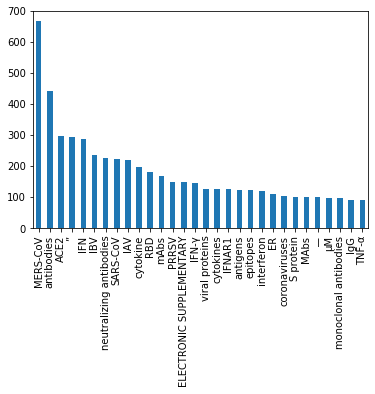

In [130]:
entity_label = 'PROTEIN'

idx_ent = np.where(s.str[1] == entity_label) # Change this string to see results for different entities

bp = s.str[0].iloc[idx_ent].value_counts().head(30)
bp.plot(kind='bar')
plt.xticks(rotation=90)
plt.show()

Interesting. We can observe serveral things in this plot:<br>
(1) MERS-CoV is the most common entity in the protein category. It is also a respiratory syndrom from the corona virus family. Thus it is probably referenced to in the literature when dealing with a novel virus of the corona family.<br>
(2) Antibodies are coming in at the second place.<br>
(3) We can see several proteins from the IFN family. They are related to regulating the immune system and immune system responses in fighting viral infections.<br>
(4) Unexpected results are quotation marks, dashes and ELECTRONIC SUPPLEMENTARY. These should be taken out in pre-processing as these are incorrectly classified as proteins.

In [136]:
# Look at abstracts with a certain keyword in them
keyword_of_interest = 'antibodies'
idx_of_interest = []

for i in range(vaccines[~vaccines.Entities.isna()].shape[0]):
    ls  = vaccines[~vaccines.Entities.isna()]['Entities'].iloc[i]
    
    for e in ls:
        if e[0] == keyword_of_interest:
            idx_of_interest.append(i)

In [137]:
b = vaccines.iloc[idx_of_interest[1]]['abstract']
doc = nlp_protein(b) # change the model to match the chosen entity category
spacy.displacy.render(doc, style='ent',jupyter=True)

By looking at an example, it becomes clear that our protein model picked up on many, but not all proteins. We would also expect MERS on line 5 to be highlighted.

Last but not least, let's take a look at how the abstracts cluster together. We compare the standard spacy model and the protein ner model and look a batch of 500 abstracts. In order for the abstract word2vec vector to perform best, we're using the pre-processed abstracts.

In [153]:
vaccines.abstract_description[0]

'december 2019 cases unidentified pneumonia history exposure huanan seafood market reported wuhan hubei province novel coronavirus sars cov-2 identified accountable disease human human transmission confirmed disease named covid-19 world health organization spread rapidly country world 18 february 2020 number confirmed cases reached 75,199 2009 fatalities covid-19 resulted lower case fatality rate 2.67 confirmed cases compared severe acute respiratory syndrome sars middle east respiratory syndrome mers symptom composition 45 fatality cases collected released official reports fever cough short breath chest tightness pain major comorbidities fatality cases include hypertension diabetes coronary heart disease cerebral infarction chronic bronchitis source virus pathogenesis disease unconfirmed specific therapeutic drug found chinese government initiated level-1 public health response prevent spread disease crucial speed development vaccines drugs treatment enable defeat covid-19 soon possib

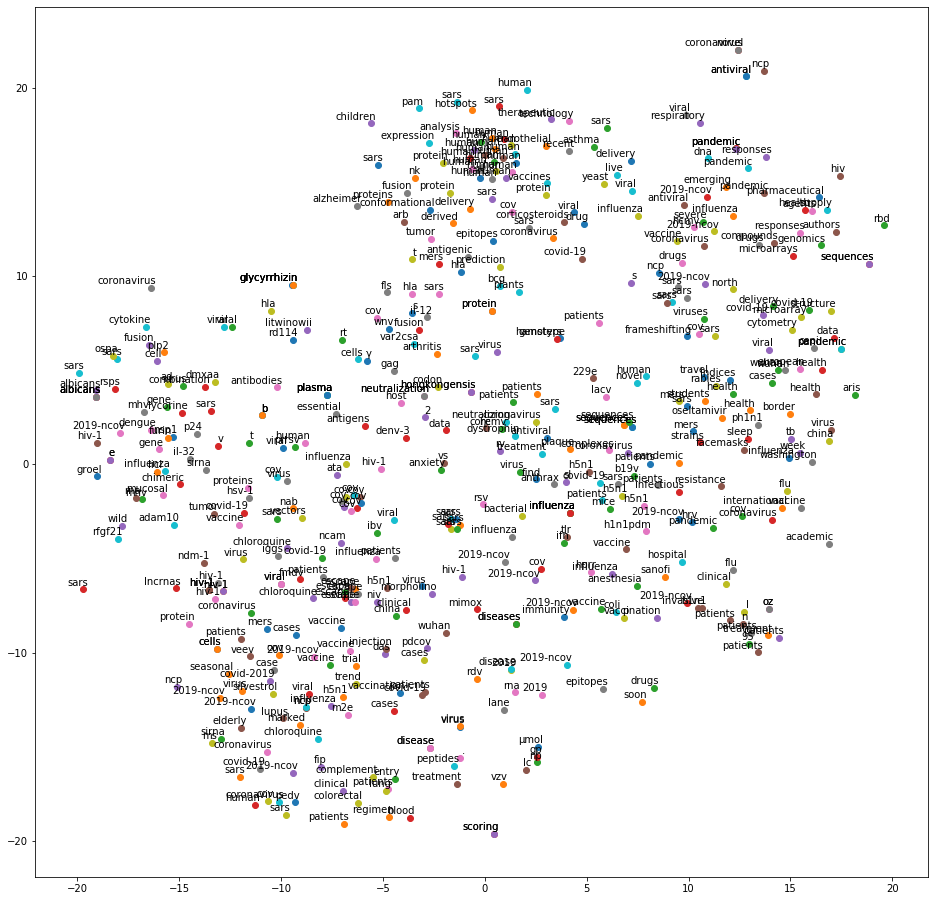

In [194]:
# Standard language model
labels = []
tokens = []

for abstract in vaccines.abstract_description[:500]: # [:5000]
    doc = nlp(abstract)
    tokens.append(doc.vector)
    words = [token.text for token in doc]
    most_common = Counter(words).most_common(1)[0][0]
    labels.append(most_common)
    
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(tokens)

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])
        
plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()

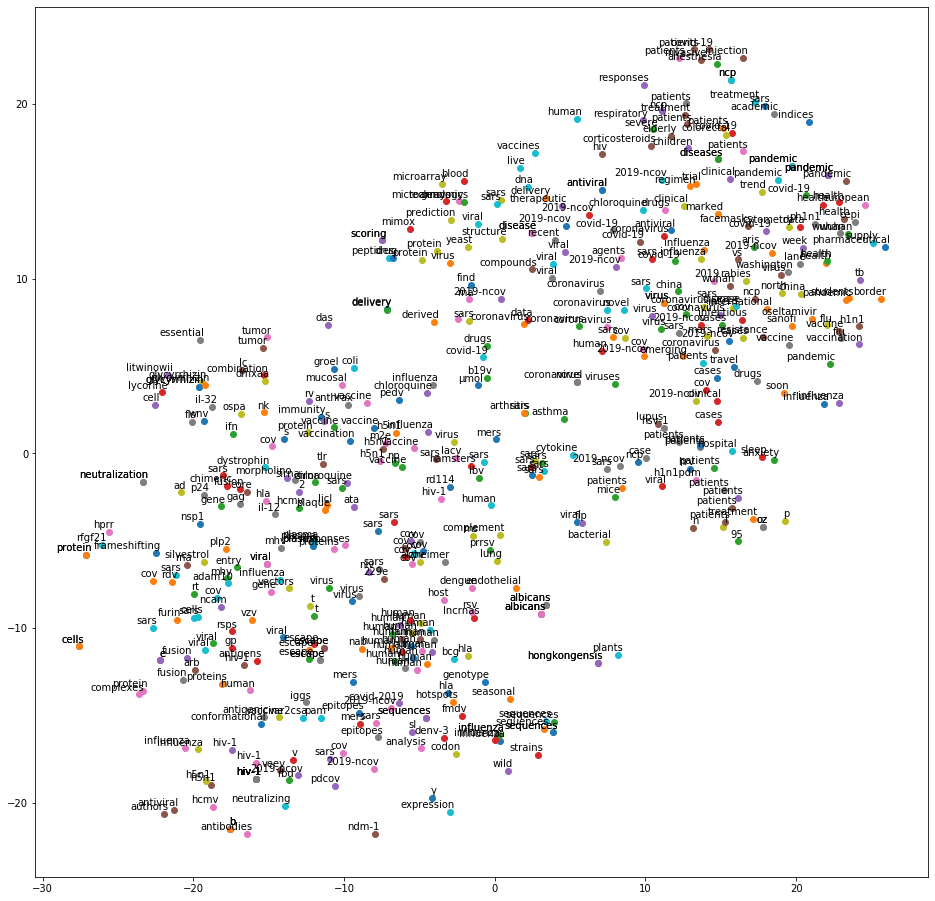

In [195]:
# Protein language model
labels = []
tokens = []

for abstract in vaccines.abstract_description[:500]: # [:5000]
    doc = nlp_protein(abstract)
    tokens.append(doc.vector)
    words = [token.text for token in doc]
    most_common = Counter(words).most_common(1)[0][0]
    labels.append(most_common)
    
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(tokens)

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])
        
plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()

Using different language models results in different TSNE representations, due to the ner models generating different document vectors. In both cases though, we can see that clusters emerge around a documents most common word. Although this metric might be one indicator about what an article is about, it is not said that this is the ultimate metric to use.

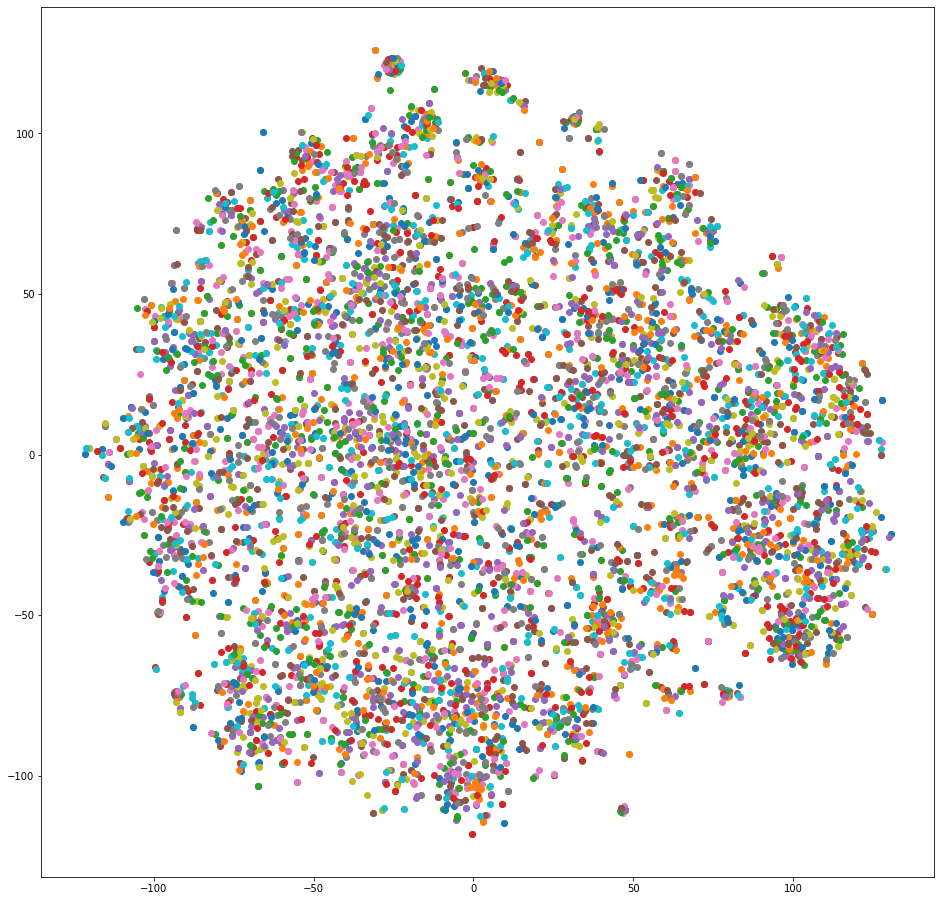

In [198]:
# Protein language model on all abstracts
labels = []
tokens = []

for abstract in vaccines.abstract_description: # [:5000]
    doc = nlp_protein(abstract)
    tokens.append(doc.vector)
    
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(tokens)

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])
        
plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])

plt.show()